In [18]:
from io import BytesIO
from pathlib import Path

import boto3
import contextily as ctx
import datashader as ds
import duckdb
import geopandas as gpd


import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import rioxarray as rio
import s2sphere
import xarray as xr
from botocore.config import Config
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from owslib.wfs import WebFeatureService
from rasterstats import zonal_stats
from scipy import integrate
from scipy.interpolate import interp1d


from shapely.geometry import box

from rasterio import features
from shapely.geometry import shape

In [19]:
def load_raster_data(url, filename=None):
    if filename:
        p = f"zip+{url}!{filename}"
    else:
        p = url
    return rio.open_rasterio(p, masked=True)


def load_wfs_layer(layer_name):
    wfs_url = "https://idecor-ws.mapascordoba.gob.ar/geoserver/idecor/wfs"
    srs = "EPSG:22174"

    # Initialize WFS connection
    wfs = WebFeatureService(url=wfs_url, version="2.0.0")

    response = wfs.getfeature(typename=layer_name, srsname=srs)

    return gpd.read_file(BytesIO(response.read()))

In [20]:
nono = load_wfs_layer("idecor:radios_urbanos")
nono = nono[nono["nombre"] == "NONO"]
nono_3857 = nono.to_crs(epsg=3857)

nono_buffered = nono_3857.copy()
nono_buffered["geometry"] = nono_buffered.geometry.buffer(
    nono_buffered.geometry.length * 0.03
)

# clip water courses and bodies of water to nono buffer bc some are juuuust outside the boundaries
cursos_agua = load_wfs_layer("idecor:cursos_agua")
cursos_agua_3857 = cursos_agua.to_crs(epsg=3857)
cursos_agua_nono_3857 = gpd.overlay(cursos_agua_3857, nono_buffered, how="intersection")

cuerpos_de_agua = load_wfs_layer("idecor:embalses")
cuerpos_de_agua_3857 = cuerpos_de_agua.to_crs(epsg=3857)
cuerpos_de_agua_nono_3857 = gpd.clip(cuerpos_de_agua_3857, nono_buffered)

argentina = gpd.read_file(
    "https://raw.githubusercontent.com/georgique/world-geojson/refs/heads/develop/countries/argentina.json"
)
argentina_3857 = argentina.to_crs(epsg=3857)

In [26]:
def setup_base_map(figsize, bounds, padding_x, padding_y):
    """Create figure and set up basic map boundaries with padding."""
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xlim(bounds[0] - padding_x, bounds[2] + padding_x)
    ax.set_ylim(bounds[1] - padding_y, bounds[3] + padding_y)
    return fig, ax


def add_basemap(ax, zoom=13):
    """Add CartoDB basemap to the axes."""
    ctx.add_basemap(
        ax,
        crs=nono_3857.crs,
        source=ctx.providers.CartoDB.PositronNoLabels,
        zorder=0,
        zoom=zoom,
    )


def add_nono_boundary(ax):
    """Add Nono boundary to the map."""
    nono_3857.plot(
        ax=ax,
        facecolor="none",
        edgecolor="#2C3E50",
        linestyle="--",
        linewidth=1.0,
        zorder=1,
    )


def scale_line_width(orden):
    return 3 - (orden - 2) * (2.5 / 3)


def add_water_features(ax):
    """Add water courses and bodies to the map."""

    for orden in sorted(cursos_agua_nono_3857["orden"].unique()):
        subset = cursos_agua_nono_3857[cursos_agua_nono_3857["orden"] == orden]
        line_width = scale_line_width(orden)
        subset.plot(
            ax=ax,
            color="#2E86C1",
            linewidth=line_width,
            alpha=0.7,
            zorder=2,
        )

    cuerpos_de_agua_nono_3857.plot(
        ax=ax, 
        color="#2E86C1",
        alpha=0.7,
        zorder=2
    )


def add_argentina_inset(ax):
    """Add Argentina inset map with Nono location."""
    axins = inset_axes(
        ax,
        width="40%",
        height="40%",
        loc="lower right",
        bbox_to_anchor=(0.1, 0.02, 1, 1),
        bbox_transform=ax.transAxes,
    )

    argentina_3857.plot(
        ax=axins,
        facecolor="grey",
        edgecolor="none",
        linewidth=0.8,
        alpha=0.3,
        zorder=1,
    )

    inset_bounds = argentina_3857.total_bounds
    inset_padding = (inset_bounds[2] - inset_bounds[0]) * 0.1
    axins.set_xlim(inset_bounds[0] - inset_padding, inset_bounds[2] + inset_padding)
    axins.set_ylim(inset_bounds[1] - inset_padding, inset_bounds[3] + inset_padding)

    nono_center = nono_3857.geometry.union_all().centroid
    axins.plot(
        nono_center.x,
        nono_center.y,
        marker="o",
        color="red",
        markersize=4,
        markeredgecolor="none",
        markeredgewidth=1,
        zorder=3,
    )

    axins.text(
        nono_center.x,
        nono_center.y - 100000,
        "Nono",
        fontsize=12,
        ha="center",
        va="top",
        color="#2C3E50",
        fontweight="bold",
        bbox=dict(
            boxstyle="round,pad=0.2",
            facecolor="none",
            alpha=1.0,
            edgecolor="none",
        ),
        zorder=4,
    )

    axins.set_axis_off()

    for spine in axins.spines.values():
        spine.set_visible(True)
        spine.set_color = "black"
        spine.set_linewidth(1)

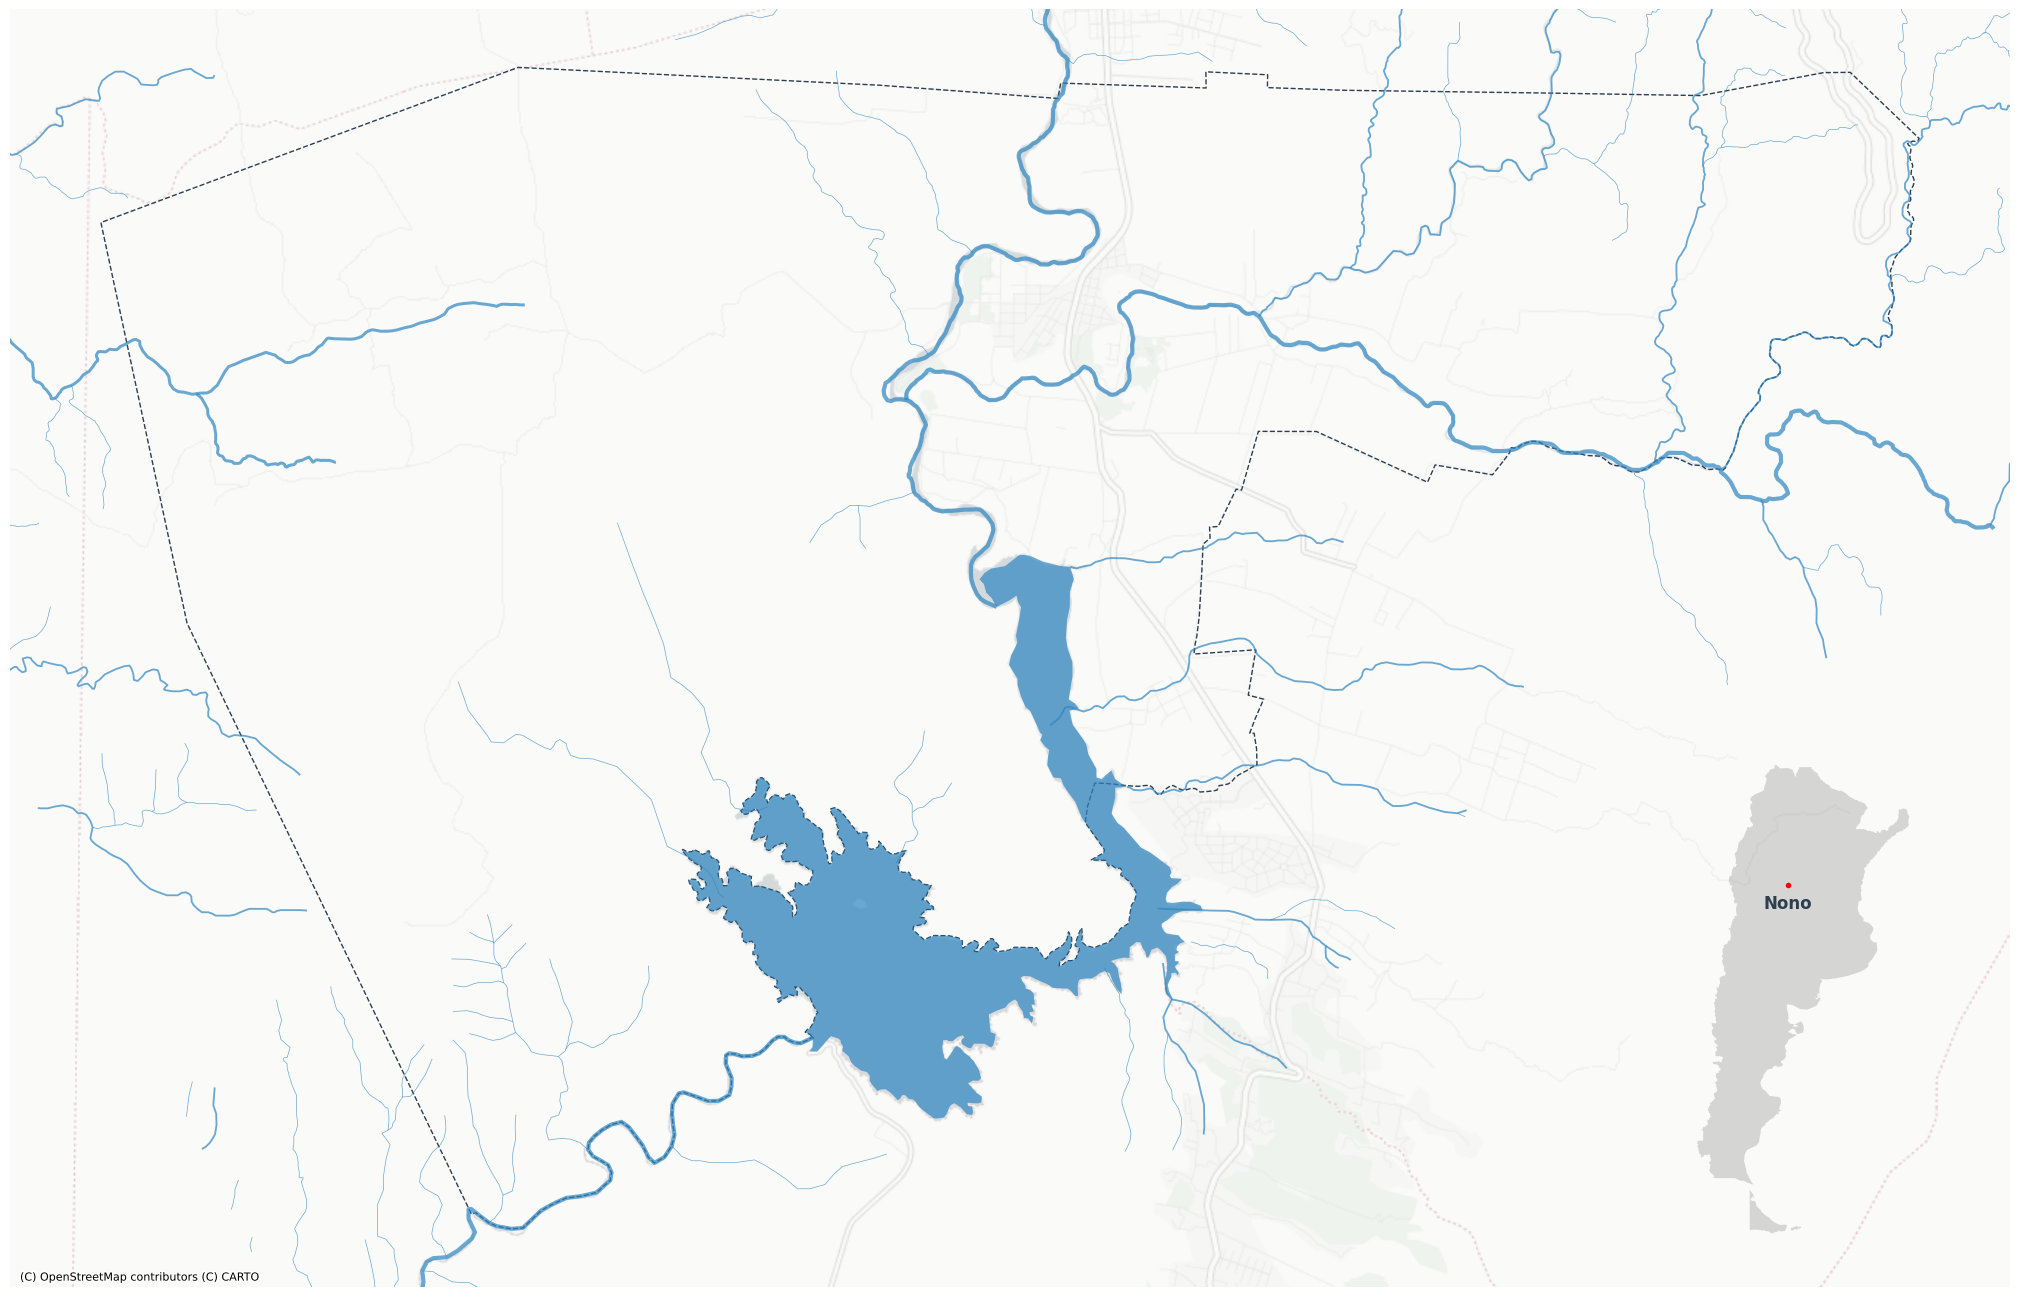

In [27]:
bounds = nono_3857.total_bounds
width = bounds[2] - bounds[0]
height = bounds[3] - bounds[1]
padding_x = width * 0.05  # add 5% padding
padding_y = height * 0.05

fig, ax = setup_base_map((20, 20), bounds, padding_x, padding_y)

add_basemap(ax)
add_water_features(ax)

add_nono_boundary(ax)

add_argentina_inset(ax)

ax.set_axis_off()
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.show()

## JRC FLood

In [23]:
flood_depth_url = (
    "https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/"
    "CEMS-GLOFAS/"
    "flood_hazard/"
    "RP100/"
    "ID74_S30_W70_RP100_depth.tif"
)
flood_depth = load_raster_data(flood_depth_url)

flood_depth_3857 = flood_depth.rio.reproject(
    dst_crs="EPSG:3857",
    resolution=100,  # 100m resolution
).rio.clip(nono_3857.geometry, from_disk=True)

In [24]:
def add_flood_layer(ax, flood_data, canvas_width=1500, canvas_height=1500):
    """Add flood depth raster to the map using datashader."""

    canvas = ds.Canvas(plot_width=canvas_width, plot_height=canvas_height)

    # Create mask for flood areas (where flood depth > 0)
    flood_mask = flood_data > 0

    # Rasterize the flood mask
    flood_agg = canvas.raster(flood_mask.sel(band=1))

    flood_agg.where(flood_agg > 0).plot.imshow(
        ax=ax,
        alpha=0.7,
        cmap="Blues",
        zorder=2,
        add_colorbar=False,
    )

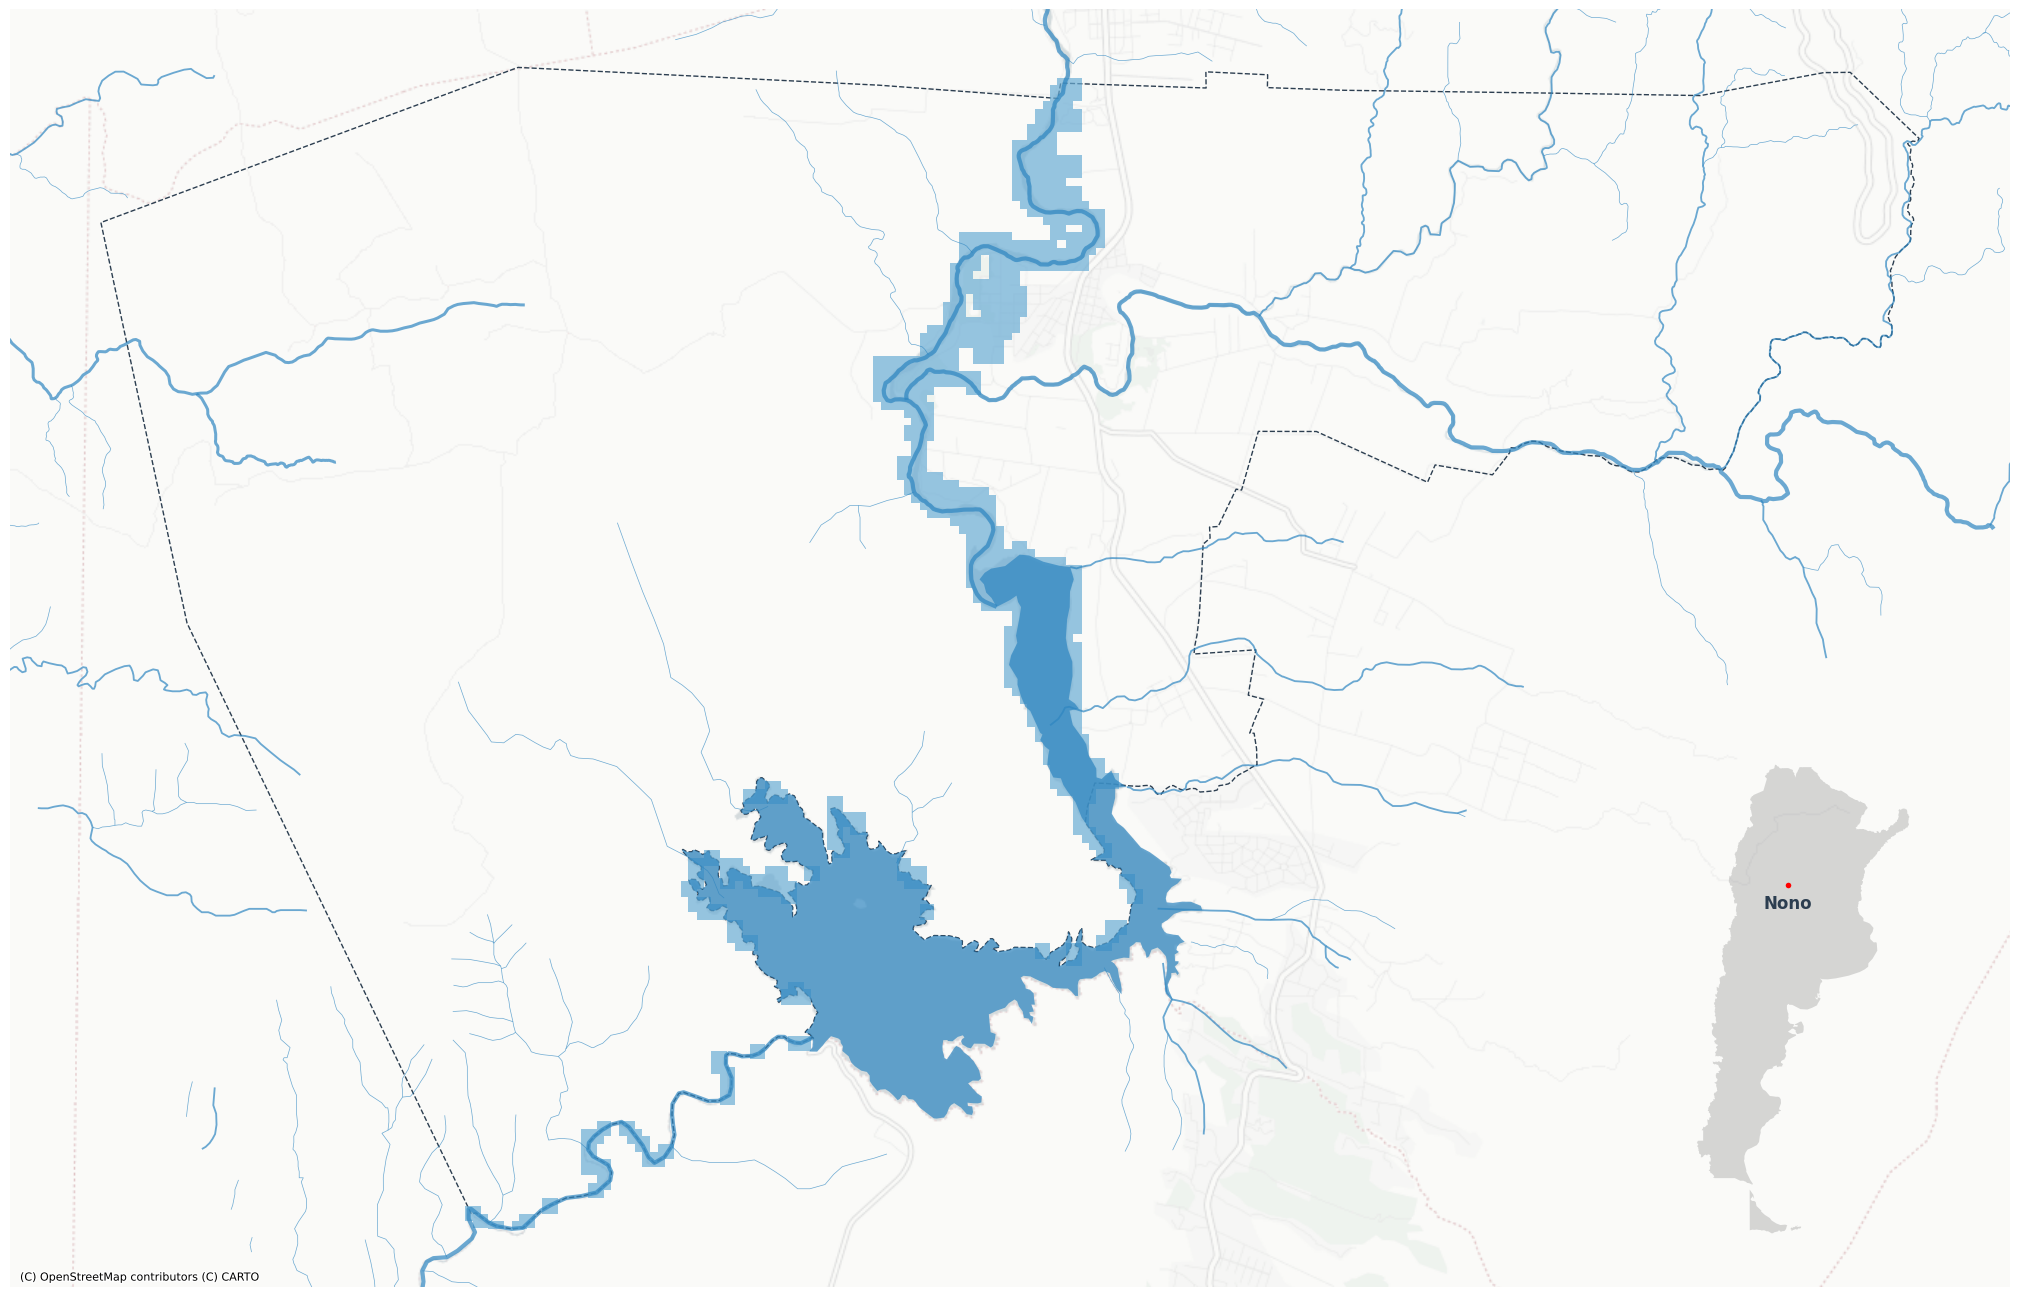

In [28]:
fig, ax = setup_base_map((20, 20), bounds, padding_x, padding_y)

add_basemap(ax)

add_flood_layer(ax, flood_depth_3857)

add_nono_boundary(ax)

add_water_features(ax)

add_argentina_inset(ax)

ax.set_axis_off()
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.show()

## GHSL

In [29]:
ghsl_url = (
    "https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/"
    "GHS_POP_GLOBE_R2023A/"
    "GHS_POP_E2025_GLOBE_R2023A_54009_100/"
    "V1-0/"
    "tiles/"
    "GHS_POP_E2025_GLOBE_R2023A_54009_100_V1_0_R13_C13.zip"
)
ghsl = load_raster_data(
    ghsl_url, "GHS_POP_E2025_GLOBE_R2023A_54009_100_V1_0_R13_C13.tif"
)

ghsl_3857 = ghsl.rio.reproject(
    dst_crs="EPSG:3857",
    resolution=100,
).rio.clip(nono_3857.geometry)

In [30]:
# Calculate centroid in Web Mercator first
center = nono_3857.geometry.centroid.iloc[0]

# Convert the centroid point to WGS84 for S2
center_wgs84 = gpd.GeoDataFrame(geometry=[center], crs="EPSG:3857").to_crs(epsg=4326)
center = center_wgs84.geometry.iloc[0]

# Get the S2 cell ID at level 10
cell = s2sphere.CellId.from_lat_lng(
    s2sphere.LatLng.from_degrees(center.y, center.x)
).parent(10)

# Configure S3 client for Source Cooperative
s3 = boto3.client(
    "s3",
    endpoint_url="https://data.source.coop",
    aws_access_key_id="",
    aws_secret_access_key="",
    config=Config(s3={"addressing_style": "path"}),
)

# List objects in the Argentina directory
response = s3.list_objects_v2(
    Bucket="vida",
    Prefix="google-microsoft-open-buildings/geoparquet/by_country_s2/country_iso=ARG/",
)

# Extract partition IDs from the keys
partitions = {
    obj["Key"].split("/")[-1].replace(".parquet", "")
    for obj in response.get("Contents", [])
}

# Check each level up to find a matching partition
for level in range(10, 0, -1):
    parent_id = str(cell.parent(level).id())

    if parent_id in partitions:
        break

# Initialize DuckDB connection
con = duckdb.connect()

# Install and load required extensions
con.execute("INSTALL spatial")
con.execute("LOAD spatial")

# Configure S3 settings
con.execute("SET s3_region='us-east-1'")
con.execute("SET s3_endpoint='data.source.coop'")
con.execute("SET s3_use_ssl=true")
con.execute("SET s3_url_style='path'")

# Convert Nono to WGS84 for spatial query
nono_wkt = nono_3857.to_crs(epsg=4326).geometry.iloc[0].wkt

# Now query with spatial filtering
query = f"""
SELECT 
    ST_AsText(geometry) as geometry_wkt,
    *
FROM read_parquet('s3://vida/google-microsoft-open-buildings/geoparquet/by_country_s2/country_iso=ARG/{parent_id}.parquet')
WHERE ST_Intersects(geometry, ST_GeomFromText('{nono_wkt}'))
"""
# query takes about 1.5 minutes to run
buildings = con.execute(query).df()

# Create GeoDataFrame using the WKT geometry column
buildings = gpd.GeoDataFrame(
    buildings,
    geometry=gpd.GeoSeries.from_wkt(buildings["geometry_wkt"]),
    crs="EPSG:4326",
)

buildings_3857 = buildings.to_crs(epsg=3857)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [31]:
def add_ghsl_layer(ax, ghsl_data, flood_mask, canvas_width=1500, canvas_height=1500):
    """Add GHSL population data to the map using datashader."""

    canvas = ds.Canvas(plot_width=canvas_width, plot_height=canvas_height)

    flood_agg = canvas.raster(flood_mask.sel(band=1))

    ghsl_agg = canvas.raster(ghsl_data.sel(band=1))

    masked_ghsl = ghsl_agg.where(flood_agg)
    masked_ghsl = masked_ghsl.where(masked_ghsl > 0)  # Only show areas with population

    masked_ghsl.plot.imshow(
        ax=ax,
        alpha=0.9,
        cmap="Reds",
        vmin=masked_ghsl.quantile(0.3),  # Start from 30th percentile to use darkest 70%
        vmax=masked_ghsl.max(),
        zorder=2,
        add_colorbar=False,
    )


def add_building_footprints(ax, buildings_data, color="#67000d", alpha=1.0):
    """Add building footprints to the map."""
    buildings_data.plot(
        ax=ax,
        color=color,
        zorder=2,
        alpha=alpha,
        edgecolor="none",
    )


def calculate_exposure_statistics(flood_gdf, ghsl_data, buildings_data, affine):
    """Calculate population and building exposure statistics."""

    stats = zonal_stats(
        flood_gdf.geometry.tolist(),
        ghsl_data.sel(band=1).values,
        stats=["sum"],
        nodata=-9999,
        affine=affine,
        all_touched=True,
    )
    population_in_flood = sum(stat["sum"] for stat in stats if stat["sum"] is not None)
    total_population = ghsl_data.sel(band=1).sum().item()
    population_percentage = (population_in_flood / total_population) * 100

    buildings_in_flood = gpd.sjoin(
        buildings_data, flood_gdf, how="inner", predicate="intersects"
    )
    # Remove duplicates that might occur from multiple intersections
    buildings_in_flood = buildings_in_flood.drop_duplicates(
        subset=buildings_in_flood.geometry.name
    )

    total_buildings = len(buildings_data)
    buildings_exposed = len(buildings_in_flood)
    buildings_percentage = (buildings_exposed / total_buildings) * 100

    # Calculate weighted centroid
    weighted_x = (
        buildings_in_flood.geometry.centroid.x * buildings_in_flood.geometry.area
    ).sum() / buildings_in_flood.geometry.area.sum()
    weighted_y = (
        buildings_in_flood.geometry.centroid.y * buildings_in_flood.geometry.area
    ).sum() / buildings_in_flood.geometry.area.sum()

    return {
        "population_in_flood": population_in_flood,
        "population_percentage": population_percentage,
        "buildings_exposed": buildings_exposed,
        "buildings_percentage": buildings_percentage,
        "buildings_in_flood": buildings_in_flood,
        "weighted_centroid": (weighted_x, weighted_y),
    }


def add_exposure_statistics(ax1, ax2, pop_stats, building_stats):
    """Add exposure statistics text to both axes."""
    population_in_flood, population_percentage = pop_stats
    buildings_exposed, buildings_percentage = building_stats

    ax1.text(
        0.98,
        0.02,
        f"Población expuesta: {population_in_flood:,.0f} ({population_percentage:.1f}%)",
        transform=ax1.transAxes,
        ha="right",
        va="bottom",
        fontsize=30,
        bbox=dict(facecolor="white", alpha=0.8, edgecolor="none", pad=5),
        zorder=4,
    )

    ax2.text(
        0.98,
        0.02,
        f"Edificios expuestos: {buildings_exposed:,} ({buildings_percentage:.1f}%)",
        transform=ax2.transAxes,
        ha="right",
        va="bottom",
        fontsize=30,
        bbox=dict(facecolor="white", alpha=0.8, edgecolor="none", pad=5),
        zorder=4,
    )

In [32]:
def create_flood_vector(flood_data):
    """Create vector representation of flood areas from raster data.

    Parameters
    ----------
    flood_data : xarray.DataArray
        Flood depth raster data

    Returns
    -------
    GeoDataFrame
        Vector representation of flood areas
    """
    # Create boolean mask and convert to uint8
    flood_mask = flood_data > 0
    mask_array = flood_mask.sel(band=1).values.astype("uint8")
    affine = flood_data.rio.transform()

    # Convert mask to polygons using rasterio.features.shapes
    shapes = features.shapes(
        mask_array,
        mask=mask_array,
        transform=affine,
        connectivity=8,  # Use 8-pixel connectivity for smoother boundaries
    )

    flood_gdf = gpd.GeoDataFrame(
        geometry=[shape(geom) for geom, val in shapes], crs=flood_data.rio.crs
    )

    return flood_gdf

In [33]:
def create_focus_area(weighted_x, weighted_y, size=2500):
    """Create a square focus area around weighted centroid."""
    square = gpd.GeoDataFrame(
        geometry=[
            box(
                weighted_x - size / 2,
                weighted_y - size / 2,
                weighted_x + size / 2,
                weighted_y + size / 2,
            )
        ],
        crs="EPSG:3857",
    )
    return square

In [34]:
# Create mask for flood areas (where flood depth > 0)
flood_mask = flood_depth_3857 > 0
mask_array = flood_mask.sel(band=1).values
affine = flood_depth_3857.rio.transform()

# Create flood vector using the function
flood_gdf = create_flood_vector(flood_depth_3857)

# Calculate all exposure statistics using the dedicated function
stats = calculate_exposure_statistics(
    flood_gdf=flood_gdf,
    ghsl_data=ghsl_3857,
    buildings_data=buildings_3857,
    affine=affine,
)

# Get all the stats we need
population_in_flood = stats["population_in_flood"]
population_percentage = stats["population_percentage"]
buildings_exposed = stats["buildings_exposed"]
buildings_percentage = stats["buildings_percentage"]
buildings_in_flood = stats["buildings_in_flood"]  # It's already calculated here!
weighted_x, weighted_y = stats["weighted_centroid"]

# Create focus area using the weighted centroid
focus_area = create_focus_area(weighted_x=weighted_x, weighted_y=weighted_y, size=2500)

In [35]:
def setup_dual_map(square_bounds, figsize):
    """Create figure with two subplots and set bounds."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    for ax in [ax1, ax2]:
        ax.set_xlim(square_bounds[0], square_bounds[2])
        ax.set_ylim(square_bounds[1], square_bounds[3])
    return fig, ax1, ax2


def add_location_inset(ax, weighted_x, weighted_y, nono_boundary):
    """Add inset map showing location within Nono."""
    axins = ax.inset_axes([0.02, 0.75, 0.3, 0.3])

    nono_boundary.plot(
        ax=axins,
        facecolor="grey",
        edgecolor="none",
        linewidth=0.8,
        alpha=0.3,
        zorder=3,
    )

    # Set inset bounds
    inset_bounds = nono_boundary.total_bounds
    inset_padding = (inset_bounds[2] - inset_bounds[0]) * 0.1
    axins.set_xlim(inset_bounds[0] - inset_padding, inset_bounds[2] + inset_padding)
    axins.set_ylim(inset_bounds[1] - inset_padding, inset_bounds[3] + inset_padding)

    # Add location marker
    axins.plot(
        weighted_x,
        weighted_y,
        marker="o",
        color="red",
        markersize=4,
        markeredgecolor="none",
        markeredgewidth=1,
        zorder=3,
    )

    axins.text(
        weighted_x,
        weighted_y - 1000,
        "Location",
        fontsize=12,
        ha="center",
        va="top",
        color="#2C3E50",
        fontweight="bold",
        bbox=dict(
            boxstyle="round,pad=0.2",
            facecolor="none",
            alpha=1.0,
            edgecolor="none",
        ),
        zorder=4,
    )

    axins.set_axis_off()


def add_population_layer(ax, masked_ghsl_data):
    """Add population exposure visualization."""
    masked_ghsl_data.plot.imshow(
        ax=ax,
        alpha=0.9,
        cmap="Reds",
        vmin=masked_ghsl_data.quantile(0.3),
        vmax=masked_ghsl_data.max(),
        zorder=2,
        add_colorbar=False,
    )


def add_buildings_layer(ax, buildings_data):
    """Add exposed buildings visualization."""
    buildings_data.plot(
        ax=ax,
        color="#67000d",
        zorder=2,
        alpha=1.0,
    )

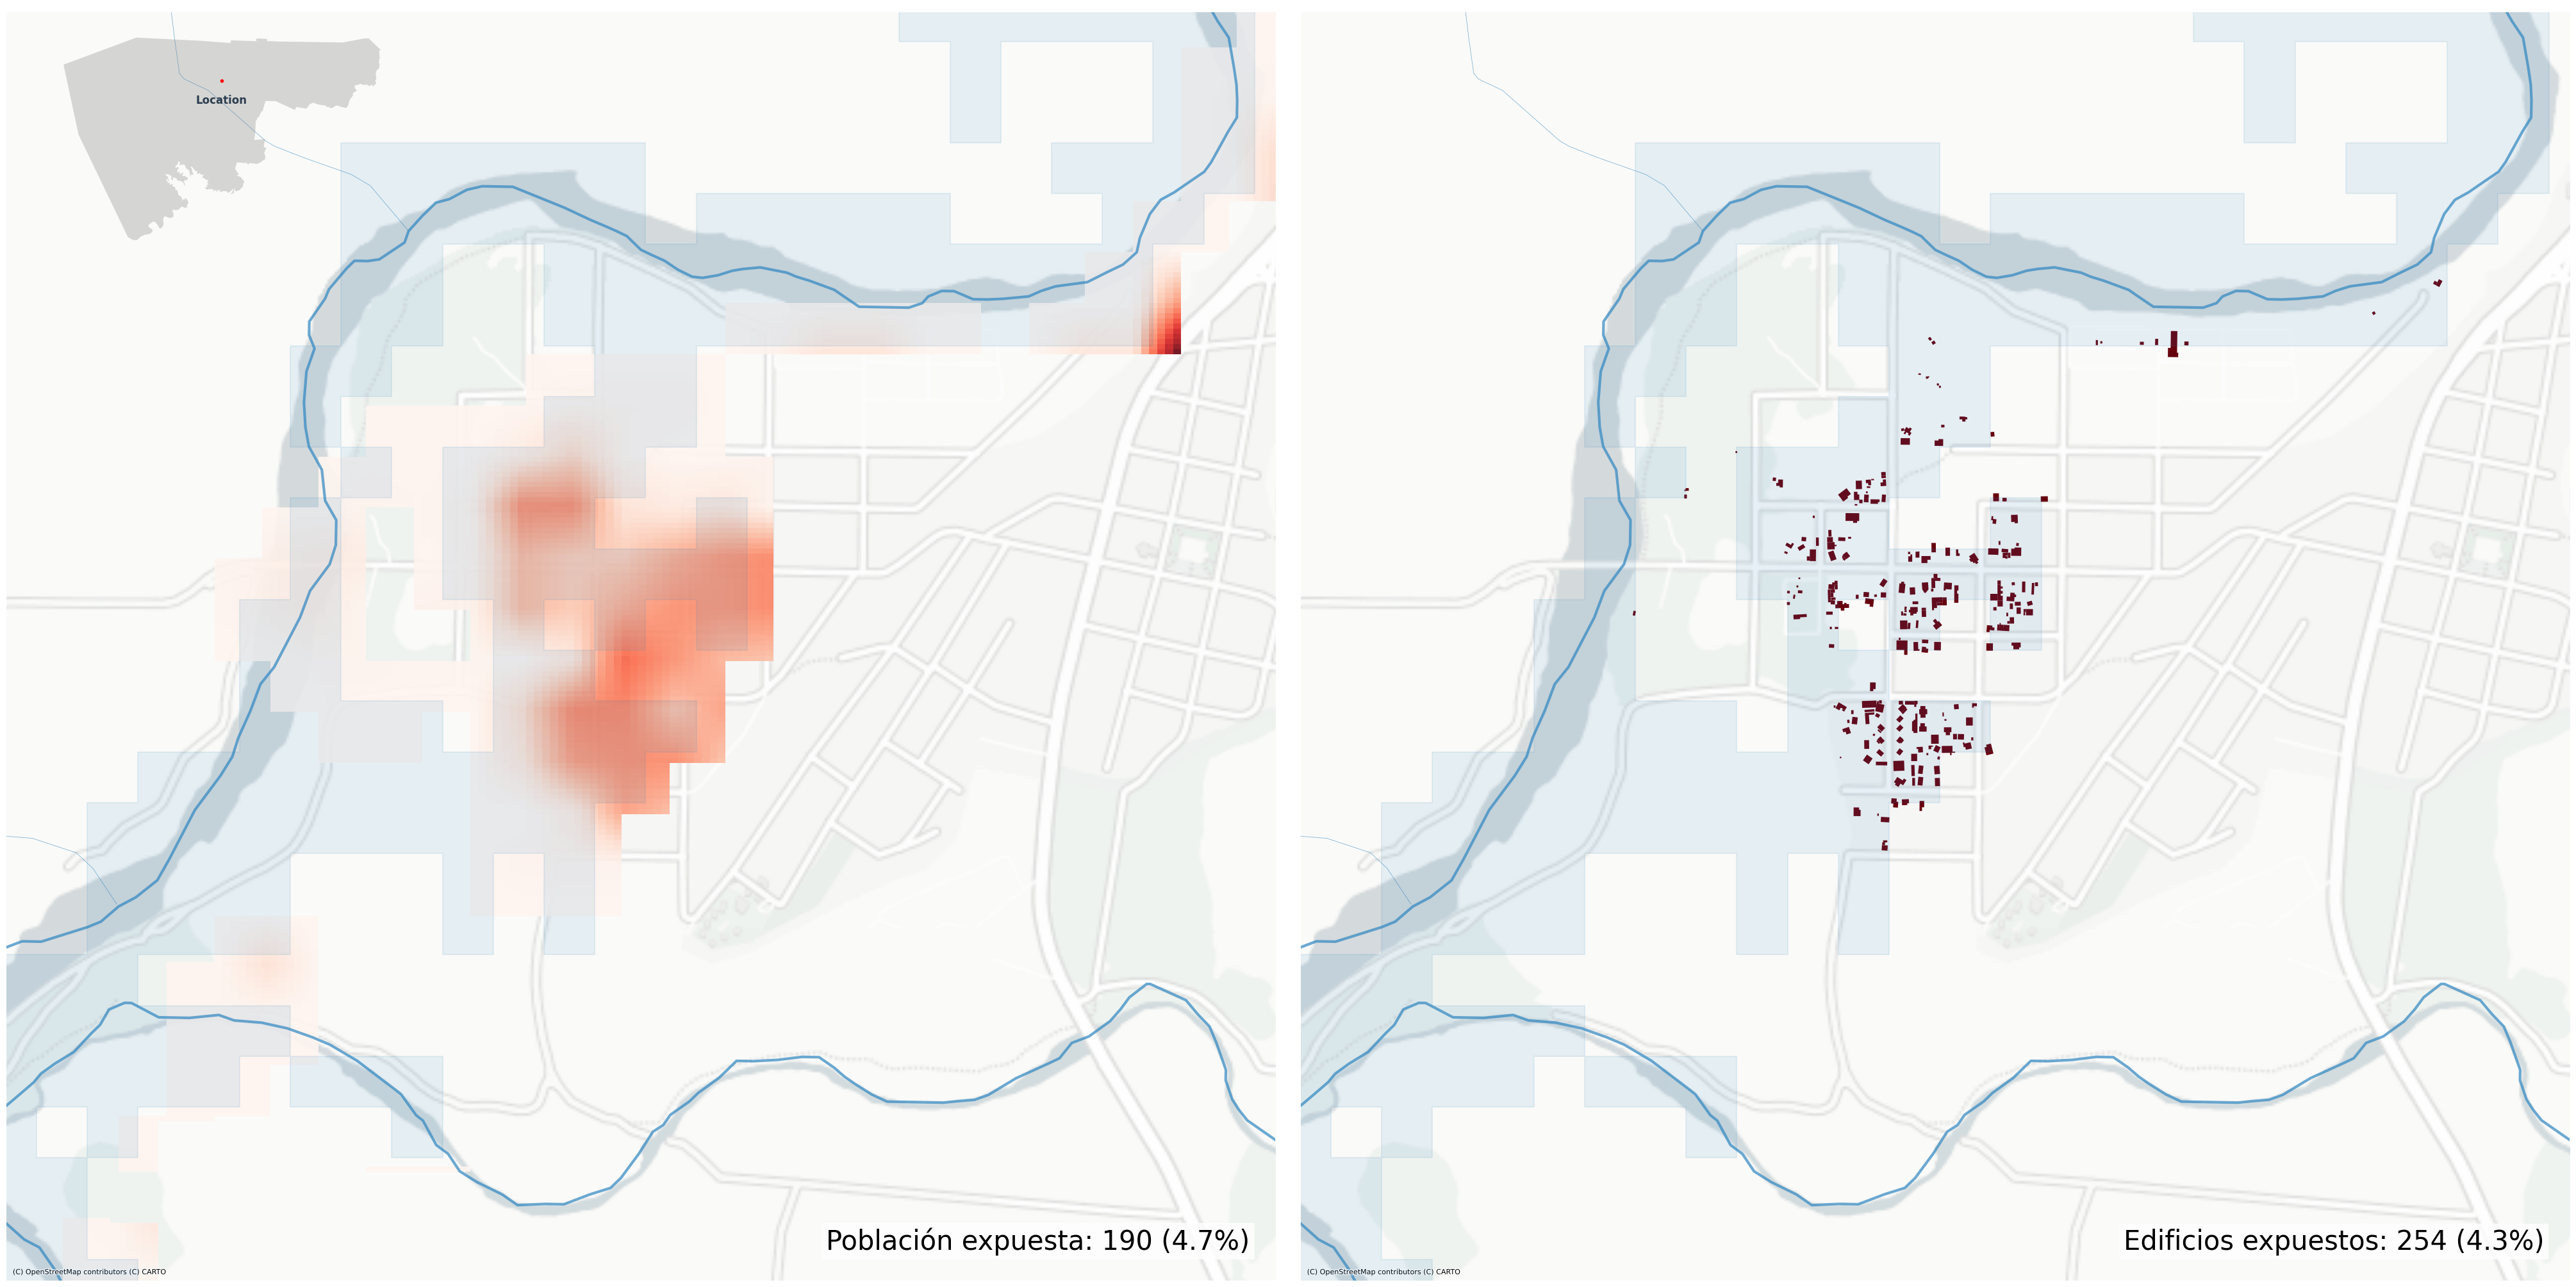

In [36]:
square_bounds = focus_area.total_bounds

# Setup dual map
fig, ax1, ax2 = setup_dual_map(square_bounds, (40, 20))

# Add location inset to first axis
add_location_inset(ax1, weighted_x, weighted_y, nono_3857)

# Create datashader canvas and process data (this stays the same)
canvas = ds.Canvas(plot_width=1500, plot_height=1500)
flood_agg = canvas.raster(flood_mask.sel(band=1))
ghsl_agg = canvas.raster(ghsl_3857.sel(band=1))
masked_ghsl = ghsl_agg.where(flood_agg).where(ghsl_agg > 0)


for ax in [ax1, ax2]:
    add_basemap(ax, zoom=15)

add_population_layer(ax1, masked_ghsl)

for ax in [ax1, ax2]:
    add_nono_boundary(ax)

    add_water_features(ax)
    flood_gdf.plot(
        ax=ax,
        facecolor="#2E86C1",
        edgecolor="#2E86C1",
        alpha=0.1,
        linewidth=1.5,
        zorder=3,
    )

add_buildings_layer(ax2, buildings_in_flood)

add_exposure_statistics(
    ax1,
    ax2,
    (population_in_flood, population_percentage),
    (buildings_exposed, buildings_percentage),
)

for ax in [ax1, ax2]:
    ax.set_axis_off()
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.02)
plt.show()

In [37]:
def load_all_return_periods(base_url, return_periods):
    """
    Load multiple return period flood depth rasters into a single xarray dataset.
    """
    datasets = []
    for i, rp in enumerate(return_periods, 1):
        url = base_url.replace("RP100", f"RP{rp}")

        flood_depth = rio.open_rasterio(url, masked=True)
        flood_depth_3857 = flood_depth.rio.reproject(
            dst_crs="EPSG:3857",
            resolution=100,
        )
        flood_depth_3857 = flood_depth_3857.rio.clip(nono_3857.geometry, from_disk=True)
        flood_depth_3857 = flood_depth_3857.expand_dims({"return_period": [rp]})
        datasets.append(flood_depth_3857)

    combined = xr.concat(datasets, dim="return_period")
    return combined


return_periods = [10, 20, 50, 75, 100, 200, 500]
base_url = "https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/CEMS-GLOFAS/flood_hazard/RP100/ID74_S30_W70_RP100_depth.tif"

flood_depths = load_all_return_periods(base_url, return_periods)

In [38]:
exposure_results = []

for rp in flood_depths.return_period.values:

    flood_data = flood_depths.sel(return_period=rp)

    flood_gdf = create_flood_vector(flood_data)

    stats = calculate_exposure_statistics(
        flood_gdf=flood_gdf,
        ghsl_data=ghsl_3857,
        buildings_data=buildings_3857,
        affine=affine,
    )

    exposure_results.append(
        {
            "return_period": rp,
            "population_exposed": stats["population_in_flood"],
            "population_percentage": stats["population_percentage"],
            "buildings_exposed": stats["buildings_exposed"],
            "buildings_percentage": stats["buildings_percentage"],
        }
    )

exposure_df = pd.DataFrame(exposure_results)

# Convert return periods to annual probabilities
exposure_df["annual_probability"] = 1 / exposure_df["return_period"]

exposure_df = exposure_df.sort_values("annual_probability")

# fit exposure curves
x_fit = np.logspace(
    np.log10(exposure_df["annual_probability"].min()),
    np.log10(exposure_df["annual_probability"].max()),
    1000,
)

f_pop = interp1d(
    exposure_df["annual_probability"],
    exposure_df["population_exposed"],
    kind="cubic",
    bounds_error=False,
    fill_value=(
        exposure_df["population_exposed"].iloc[0],
        exposure_df["population_exposed"].iloc[-1],
    ),
)
y_fit_pop = f_pop(x_fit)

f_build = interp1d(
    exposure_df["annual_probability"],
    exposure_df["buildings_exposed"],
    kind="cubic",
    bounds_error=False,
    fill_value=(
        exposure_df["buildings_exposed"].iloc[0],
        exposure_df["buildings_exposed"].iloc[-1],
    ),
)
y_fit_build = f_build(x_fit)


def calculate_expected_annual_impact_smooth(prob_array, exposure_function):
    """
    Calculate expected annual impact using smooth interpolated curve.

    Parameters:
    prob_array: array of probability values
    exposure_function: interpolation function that gives exposure for given probability
    """
    # Integrate the interpolated function
    expected_impact, _ = integrate.quad(
        exposure_function, prob_array.min(), prob_array.max()
    )
    return expected_impact


expected_pop = calculate_expected_annual_impact_smooth(x_fit, f_pop)
expected_buildings = calculate_expected_annual_impact_smooth(x_fit, f_build)

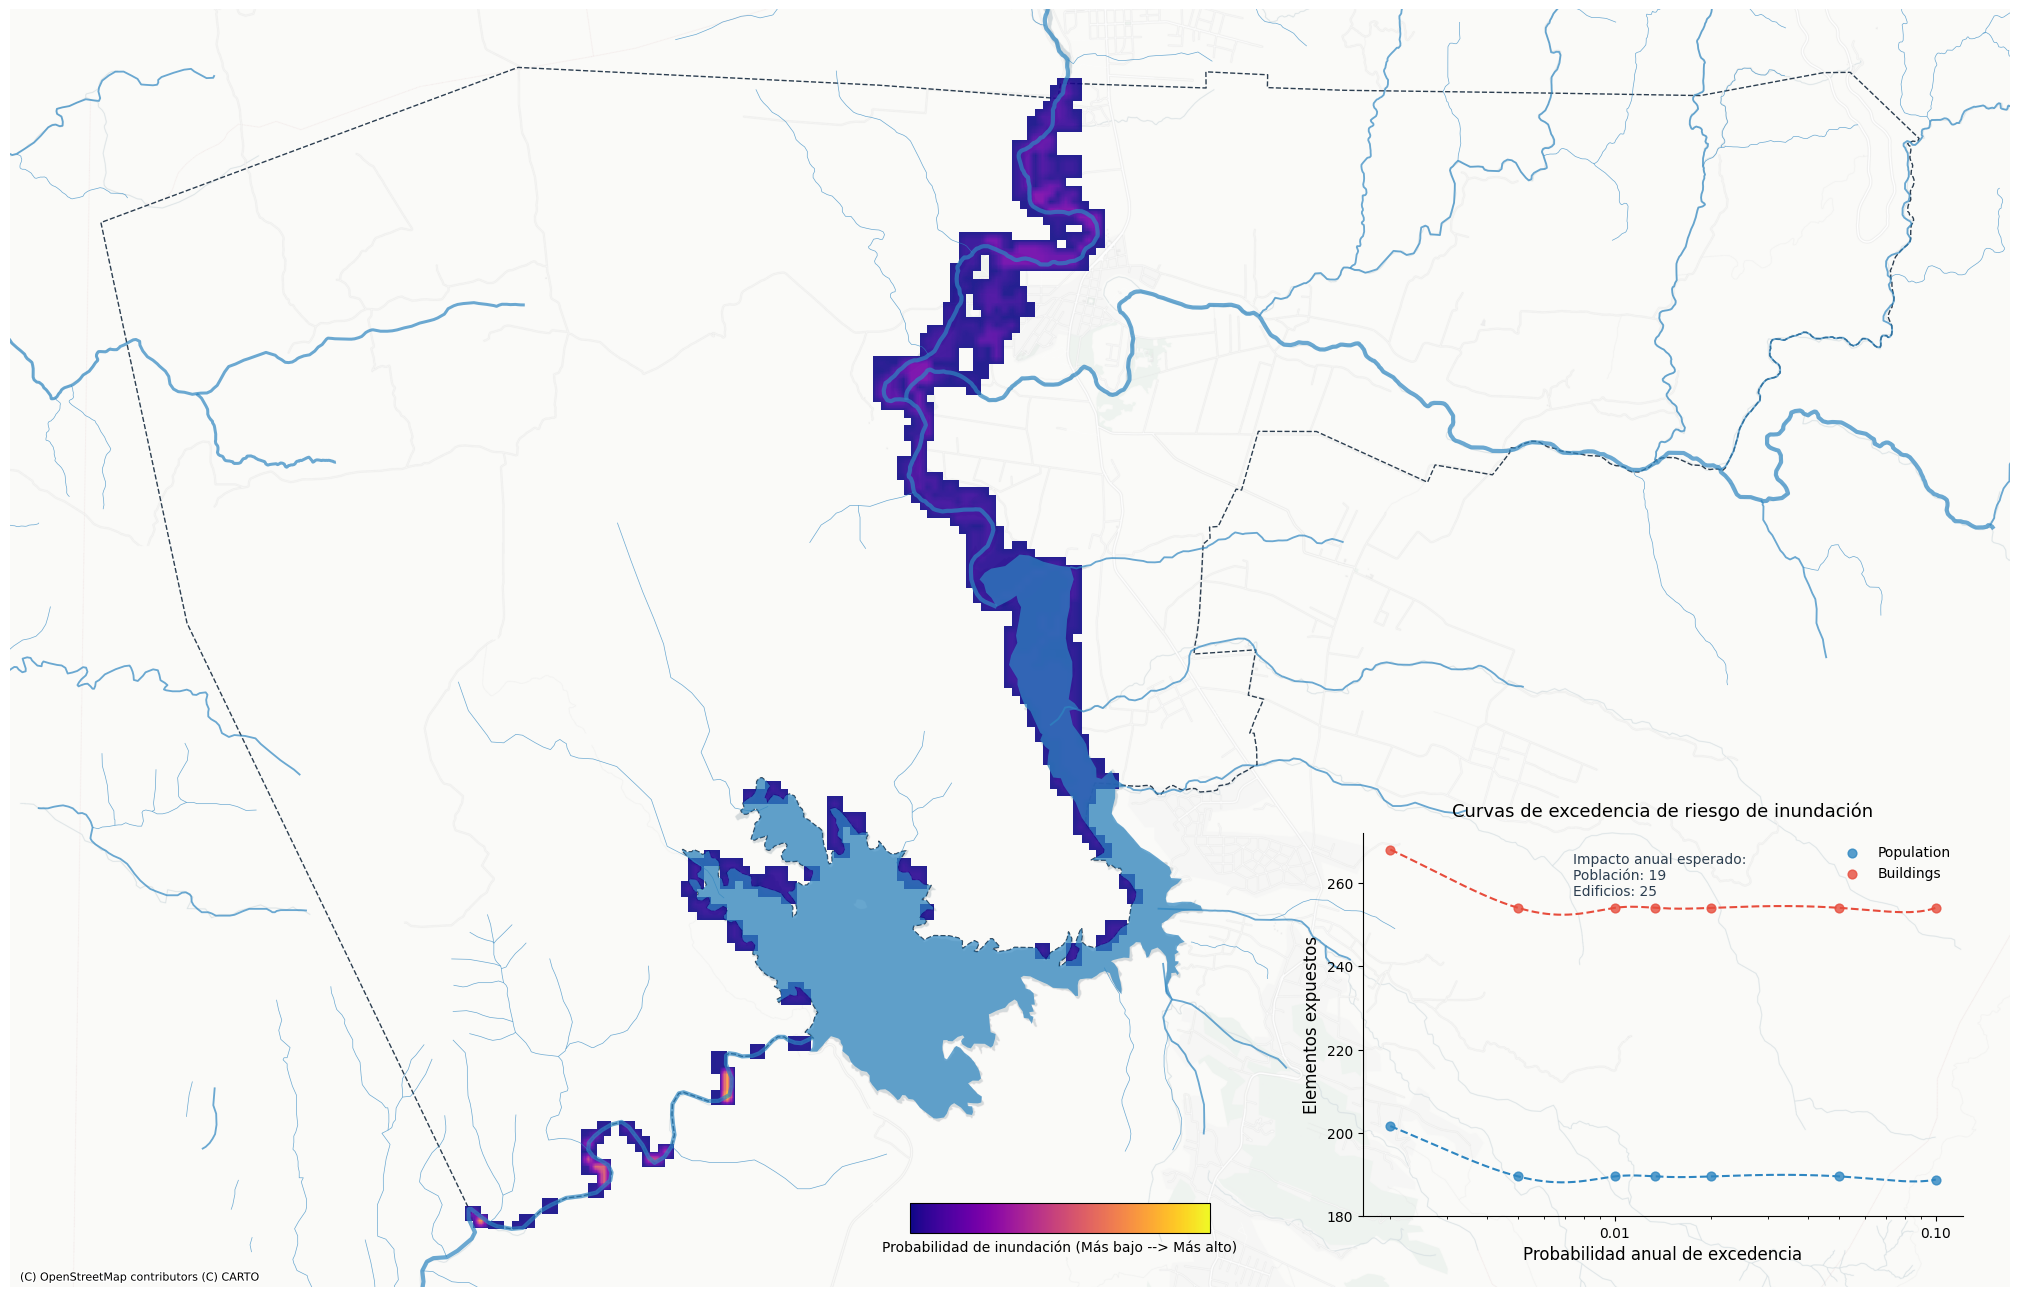

In [39]:
fig, ax1 = plt.subplots(1, 1, figsize=(20, 15))

# Set the plot limits to match the Nono boundary for the map
bounds = nono_3857.total_bounds
width = bounds[2] - bounds[0]
height = bounds[3] - bounds[1]
padding_x = width * 0.05
padding_y = height * 0.05
ax1.set_xlim(bounds[0] - padding_x, bounds[2] + padding_x)
ax1.set_ylim(bounds[1] - padding_y, bounds[3] + padding_y)


canvas = ds.Canvas(plot_width=1500, plot_height=1500)

# Sum flood depths across return periods
flood_sum = flood_depths.sum(dim="return_period")

# Rasterize the summed flood data
flood_agg = canvas.raster(flood_sum.sel(band=1))

add_basemap(ax1, zoom=15)

# Plot the summed flood data
flood_agg.where(flood_agg > 0).plot.imshow(
    ax=ax1, cmap="plasma", zorder=2, add_colorbar=False, alpha=0.9
)

add_water_features(ax1)

add_nono_boundary(ax1)

# Create inset for exceedance curve using inset_axes
axins = inset_axes(
    ax1,
    width="30%",
    height="30%",
    loc="lower right",
    bbox_to_anchor=(-0.02, 0.05, 1, 1),
    bbox_transform=ax1.transAxes,
)

# Plot both population and buildings data points
axins.scatter(
    exposure_df["annual_probability"],
    exposure_df["population_exposed"],
    color="#2E86C1",  # Blue for population
    s=40,
    alpha=0.8,
    label="Population",
)

axins.scatter(
    exposure_df["annual_probability"],
    exposure_df["buildings_exposed"],
    color="#E74C3C",  # Red for buildings
    s=40,
    alpha=0.8,
    label="Buildings",
)

# Plot the fitted curves
axins.plot(
    x_fit, f_pop(x_fit), color="#2E86C1", linewidth=1.5, linestyle="--", label="_nolegend_"
)
axins.plot(
    x_fit,
    f_build(x_fit),
    color="#E74C3C",
    linewidth=1.5,
    linestyle="--",
    label="_nolegend_",
)

axins.set_xlabel("Probabilidad anual de excedencia", fontsize=12)
axins.set_ylabel("Elementos expuestos", fontsize=12)
axins.set_title("Curvas de excedencia de riesgo de inundación", fontsize=13, pad=12)


axins.set_xscale("log")
axins.set_ylim(bottom=180)
axins.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{x:.2f}"))

axins.legend(fontsize=10, frameon=False)

axins.text(
    0.35,  
    0.95,
    f"Impacto anual esperado:\nPoblación: {expected_pop:,.0f}\nEdificios: {expected_buildings:,.0f}",
    transform=axins.transAxes,
    verticalalignment="top",
    fontsize=10,
    color="#2C3E50",
)

axins.grid(False)
axins.spines["top"].set_visible(False)
axins.spines["right"].set_visible(False)
axins.spines["left"].set_visible(True)
axins.spines["bottom"].set_visible(True)
axins.tick_params(axis="both", which="major", labelsize=10)

axins.patch.set_facecolor("none")
axins.patch.set_zorder(0)

ax1.set_axis_off()

# Get the maximum flood depth value for the colorbar normalization
max_flood_depth = flood_agg.max().item()

# Create a colormap and normalization object for the colorbar
cmap = plt.colormaps["plasma"]  # Updated syntax
norm = mcolors.Normalize(vmin=0, vmax=max_flood_depth)
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Create a new axes for the colorbar at the bottom of the figure
cbar_ax = fig.add_axes([0.45, 0.11, 0.15, 0.02])

# Create the colorbar using the ScalarMappable and the dedicated axes
cbar = fig.colorbar(sm, cax=cbar_ax, orientation="horizontal")

cbar.set_ticks([])
cbar.set_ticklabels([])

# Set the label for the colorbar
cbar.set_label(
    "Probabilidad de inundación (Más bajo --> Más alto)",
    fontsize=10,
    ha="center",
    labelpad=5,
)

plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.show()

## Scratch

In [2]:
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)

project_root = Path.cwd().parent

In [3]:
COLORS = {
    "water": "#2E86C1",  # Blue for water courses
    "buildings": "#E67E22",  # Orange for buildings
    "flood": "#3498DB",  # Light blue for flood areas
    "population": "#E74C3C",  # Red for population density
    "exceedance": "#2E86C1",  # Blue for exceedance curve
    "exceedance_fit": "#E74C3C",  # Red for fitted curve
    "boundary": "#2C3E50",  # Dark blue-gray for boundaries
    "background": "#F8F9FA",  # Light gray for backgrounds
    "text": "#2C3E50",  # Dark blue-gray for text
    "highlight": "#27AE60",  # Green for highlights
}

VIZ = {
    "figsize_single": (20, 20),
    "figsize_dual": (40, 20),
    "alpha_base": 0.3,
    "alpha_main": 0.7,
    "alpha_highlight": 0.9,
    "alpha_text": 1.0,
    "linewidth_boundary": 1.0,
    "linewidth_water": 1.5,
    "linewidth_highlight": 2.0,
    "zorder_background": 0,
    "zorder_base": 1,
    "zorder_main": 2,
    "zorder_highlight": 3,
    "zorder_text": 4,
    "fontsize_title": 24,
    "fontsize_subtitle": 18,
    "fontsize_label": 14,
    "fontsize_annotation": 12,
    "inset_size": 0.3,  # 30% of main figure
}

In [4]:
def load_raster_data(url, filename=None):
    if filename:
        p = f"zip+{url}!{filename}"
    else:
        p = url
    return rio.open_rasterio(p, masked=True)


def load_wfs_layer(layer_name):
    wfs_url = "https://idecor-ws.mapascordoba.gob.ar/geoserver/idecor/wfs"
    srs = "EPSG:22174"

    # Initialize WFS connection
    wfs = WebFeatureService(url=wfs_url, version="2.0.0")

    response = wfs.getfeature(typename=layer_name, srsname=srs)

    return gpd.read_file(BytesIO(response.read()))


# function to scale line width in biz based on stream order
def scale_line_width(orden):
    return 3 - (orden - 2) * (2.5 / 3)

# GEV function
def gev_function(x, loc, scale, shape):
    return genextreme.ppf(1 - x, shape, loc=loc, scale=scale)

In [5]:
nono = load_wfs_layer("idecor:radios_urbanos")
nono = nono[nono["nombre"] == "NONO"]
nono_3857 = nono.to_crs(epsg=3857)

nono_buffered = nono_3857.copy()
nono_buffered["geometry"] = nono_buffered.geometry.buffer(
    nono_buffered.geometry.length * 0.03
)

# clip water courses and bodies of water to nono buffer bc some are juuuust outside the boundaries
cursos_agua = load_wfs_layer("idecor:cursos_agua")
cursos_agua_3857 = cursos_agua.to_crs(epsg=3857)
cursos_agua_nono_3857 = gpd.overlay(cursos_agua_3857, nono_buffered, how="intersection")

cuerpos_de_agua = load_wfs_layer("idecor:embalses")
cuerpos_de_agua_3857 = cuerpos_de_agua.to_crs(epsg=3857)
cuerpos_de_agua_nono_3857 = gpd.clip(cuerpos_de_agua_3857, nono_buffered)

In [6]:
argentina = gpd.read_file(
    "https://raw.githubusercontent.com/georgique/world-geojson/refs/heads/develop/countries/argentina.json"
)
argentina_3857 = argentina.to_crs(epsg=3857)

/tmp/ipykernel_357263/1284552003.py:78: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  nono_center = nono_3857.geometry.unary_union.centroid


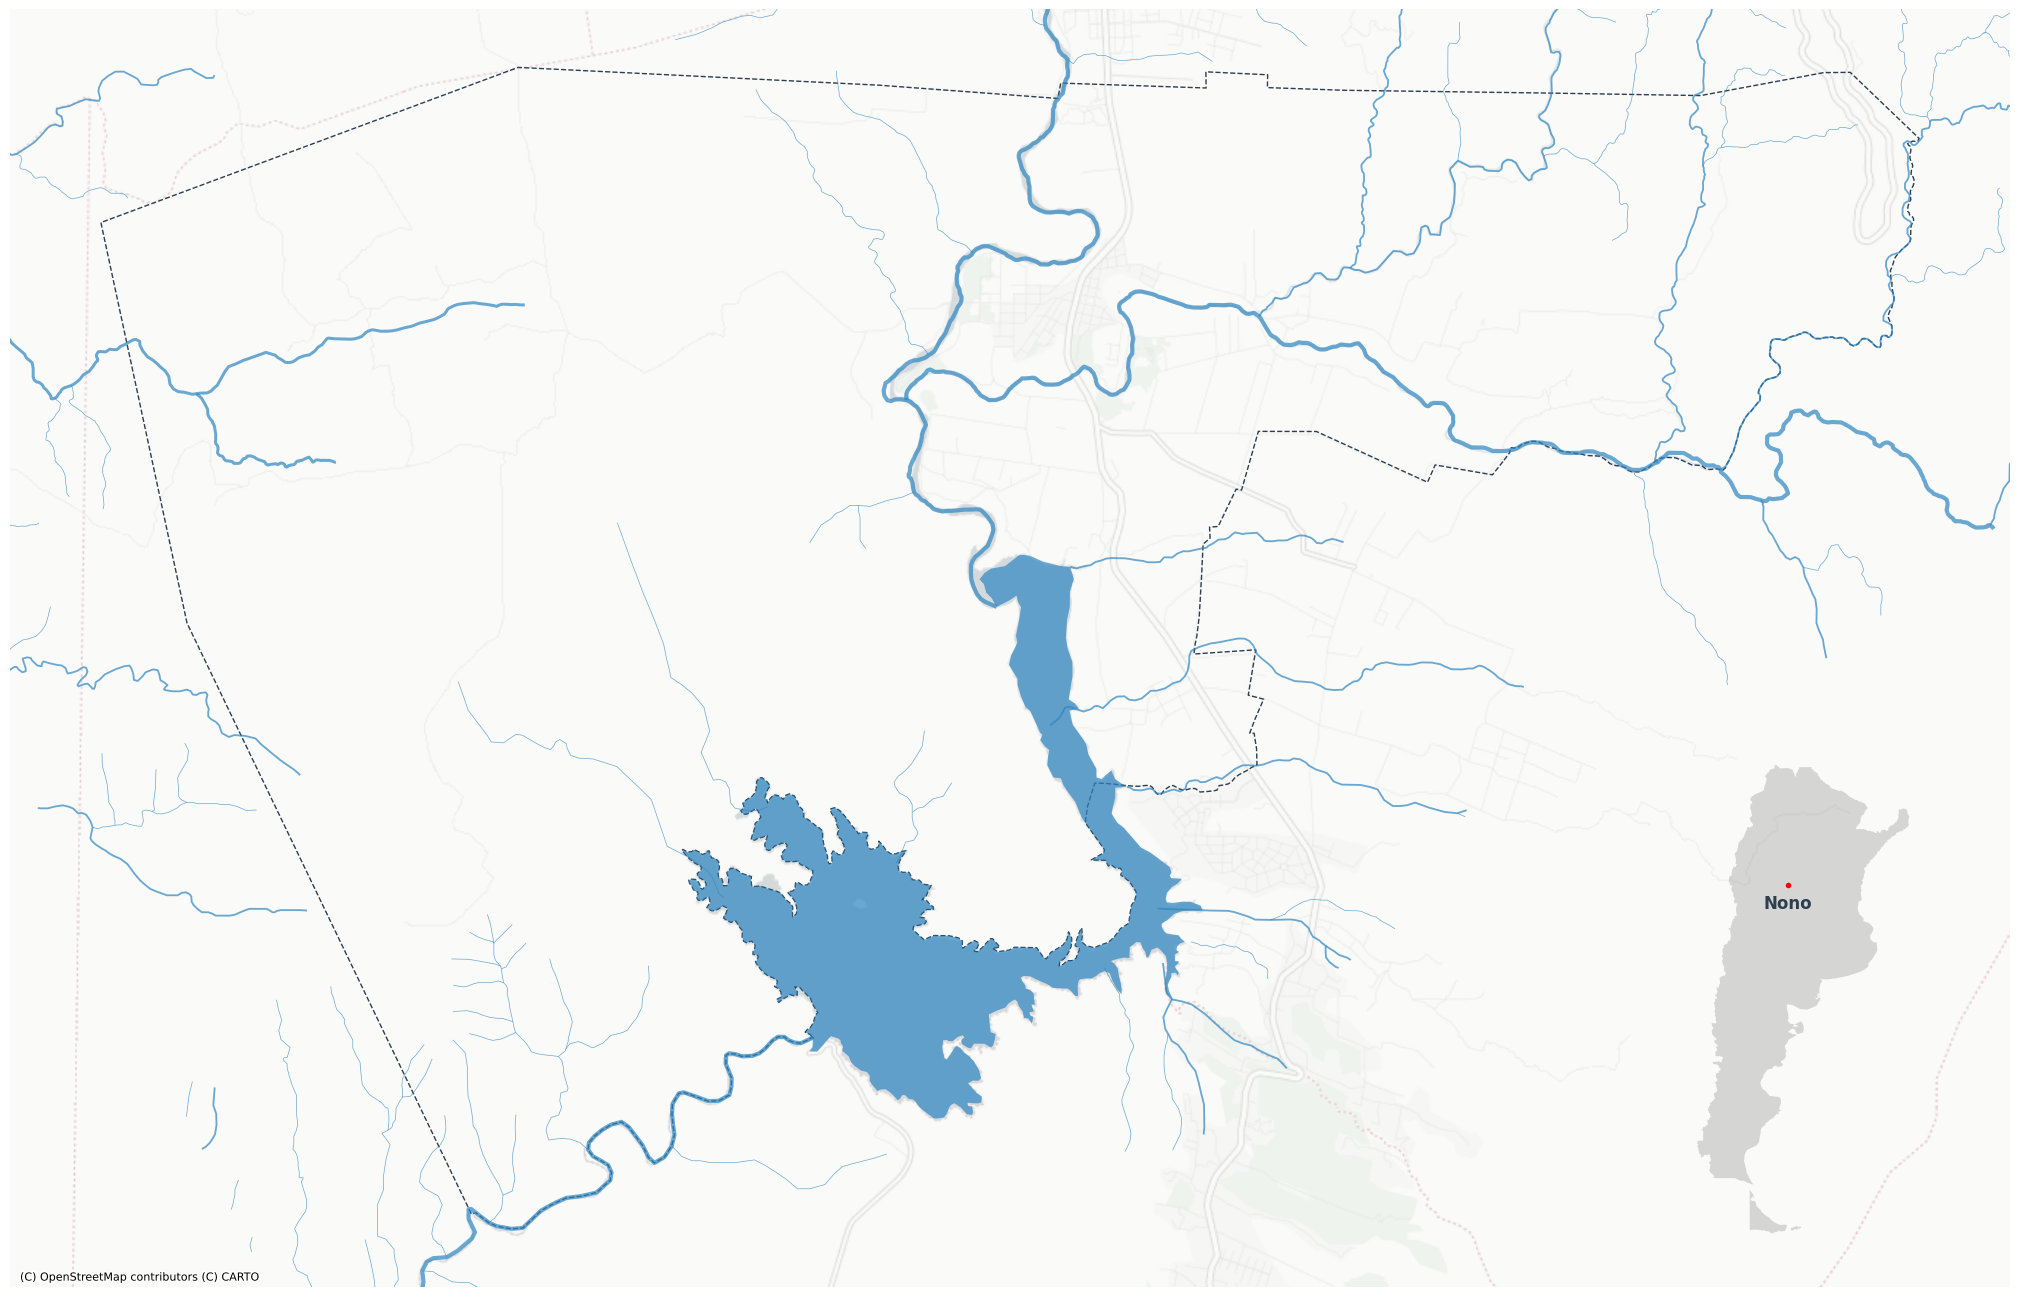

In [7]:
fig, ax = plt.subplots(figsize=VIZ["figsize_single"])

bounds = nono_3857.total_bounds
width = bounds[2] - bounds[0]
height = bounds[3] - bounds[1]
padding_x = width * 0.05 # add 5% padding
padding_y = height * 0.05
ax.set_xlim(bounds[0] - padding_x, bounds[2] + padding_x)
ax.set_ylim(bounds[1] - padding_y, bounds[3] + padding_y)

ctx.add_basemap(
    ax,
    crs=nono_3857.crs,
    source=ctx.providers.CartoDB.PositronNoLabels,
    zorder=VIZ["zorder_background"],
    zoom=13,
)

nono_3857.plot(
    ax=ax,
    facecolor="none",
    edgecolor=COLORS["boundary"],
    linestyle="--",
    linewidth=VIZ["linewidth_boundary"],
    zorder=VIZ["zorder_base"],
)

for orden in sorted(cursos_agua_nono_3857["orden"].unique()):
    subset = cursos_agua_nono_3857[cursos_agua_nono_3857["orden"] == orden]
    line_width = scale_line_width(orden)
    subset.plot(
        ax=ax,
        color=COLORS["water"],
        linewidth=line_width,
        alpha=VIZ["alpha_main"],
        zorder=VIZ["zorder_main"],
    )

cuerpos_de_agua_nono_3857.plot(
    ax=ax, color=COLORS["water"], alpha=VIZ["alpha_main"], zorder=VIZ["zorder_main"]
)

axins = inset_axes(
    ax,
    width="40%",
    height="40%",
    loc="lower right",
    bbox_to_anchor=(0.1, 0.02, 1, 1),
    bbox_transform=ax.transAxes,
)

argentina_3857.plot(
    ax=axins,
    facecolor="grey",
    edgecolor="none",
    linewidth=0.8,
    alpha=0.3,
    zorder=VIZ["zorder_base"],
)

# Set inset limits to show Argentina with some padding
inset_bounds = argentina_3857.total_bounds
inset_padding = (inset_bounds[2] - inset_bounds[0]) * 0.1
axins.set_xlim(inset_bounds[0] - inset_padding, inset_bounds[2] + inset_padding)
axins.set_ylim(inset_bounds[1] - inset_padding, inset_bounds[3] + inset_padding)

# Add point marker for Nono's location
nono_center = nono_3857.geometry.unary_union.centroid
axins.plot(
    nono_center.x,
    nono_center.y,
    marker="o",
    color="red",
    markersize=4,
    markeredgecolor="none",
    markeredgewidth=1,
    zorder=VIZ["zorder_highlight"],
)

axins.text(
    nono_center.x,
    nono_center.y - 100000,
    "Nono",
    fontsize=VIZ["fontsize_annotation"],
    ha="center",
    va="top",
    color=COLORS["text"],
    fontweight="bold",
    bbox=dict(
        boxstyle="round,pad=0.2",
        facecolor="none",
        alpha=VIZ["alpha_text"],
        edgecolor="none",
    ),
    zorder=VIZ["zorder_text"],
)

ax.set_axis_off()
axins.set_axis_off()

# Add a clean border around the inset map
for spine in axins.spines.values():
    spine.set_visible(True)
    spine.set_color = "black"
    spine.set_linewidth(1)

# Remove all padding
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.show()

In [8]:
flood_depth_url = "https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/CEMS-GLOFAS/flood_hazard/RP100/ID74_S30_W70_RP100_depth.tif"
flood_depth = load_raster_data(flood_depth_url)

flood_depth_3857 = flood_depth.rio.reproject(
    dst_crs="EPSG:3857",
    resolution=100,  # 100m resolution
).rio.clip(nono_3857.geometry, from_disk=True)

/tmp/ipykernel_357263/1239796449.py:94: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  nono_center = nono_3857.geometry.unary_union.centroid


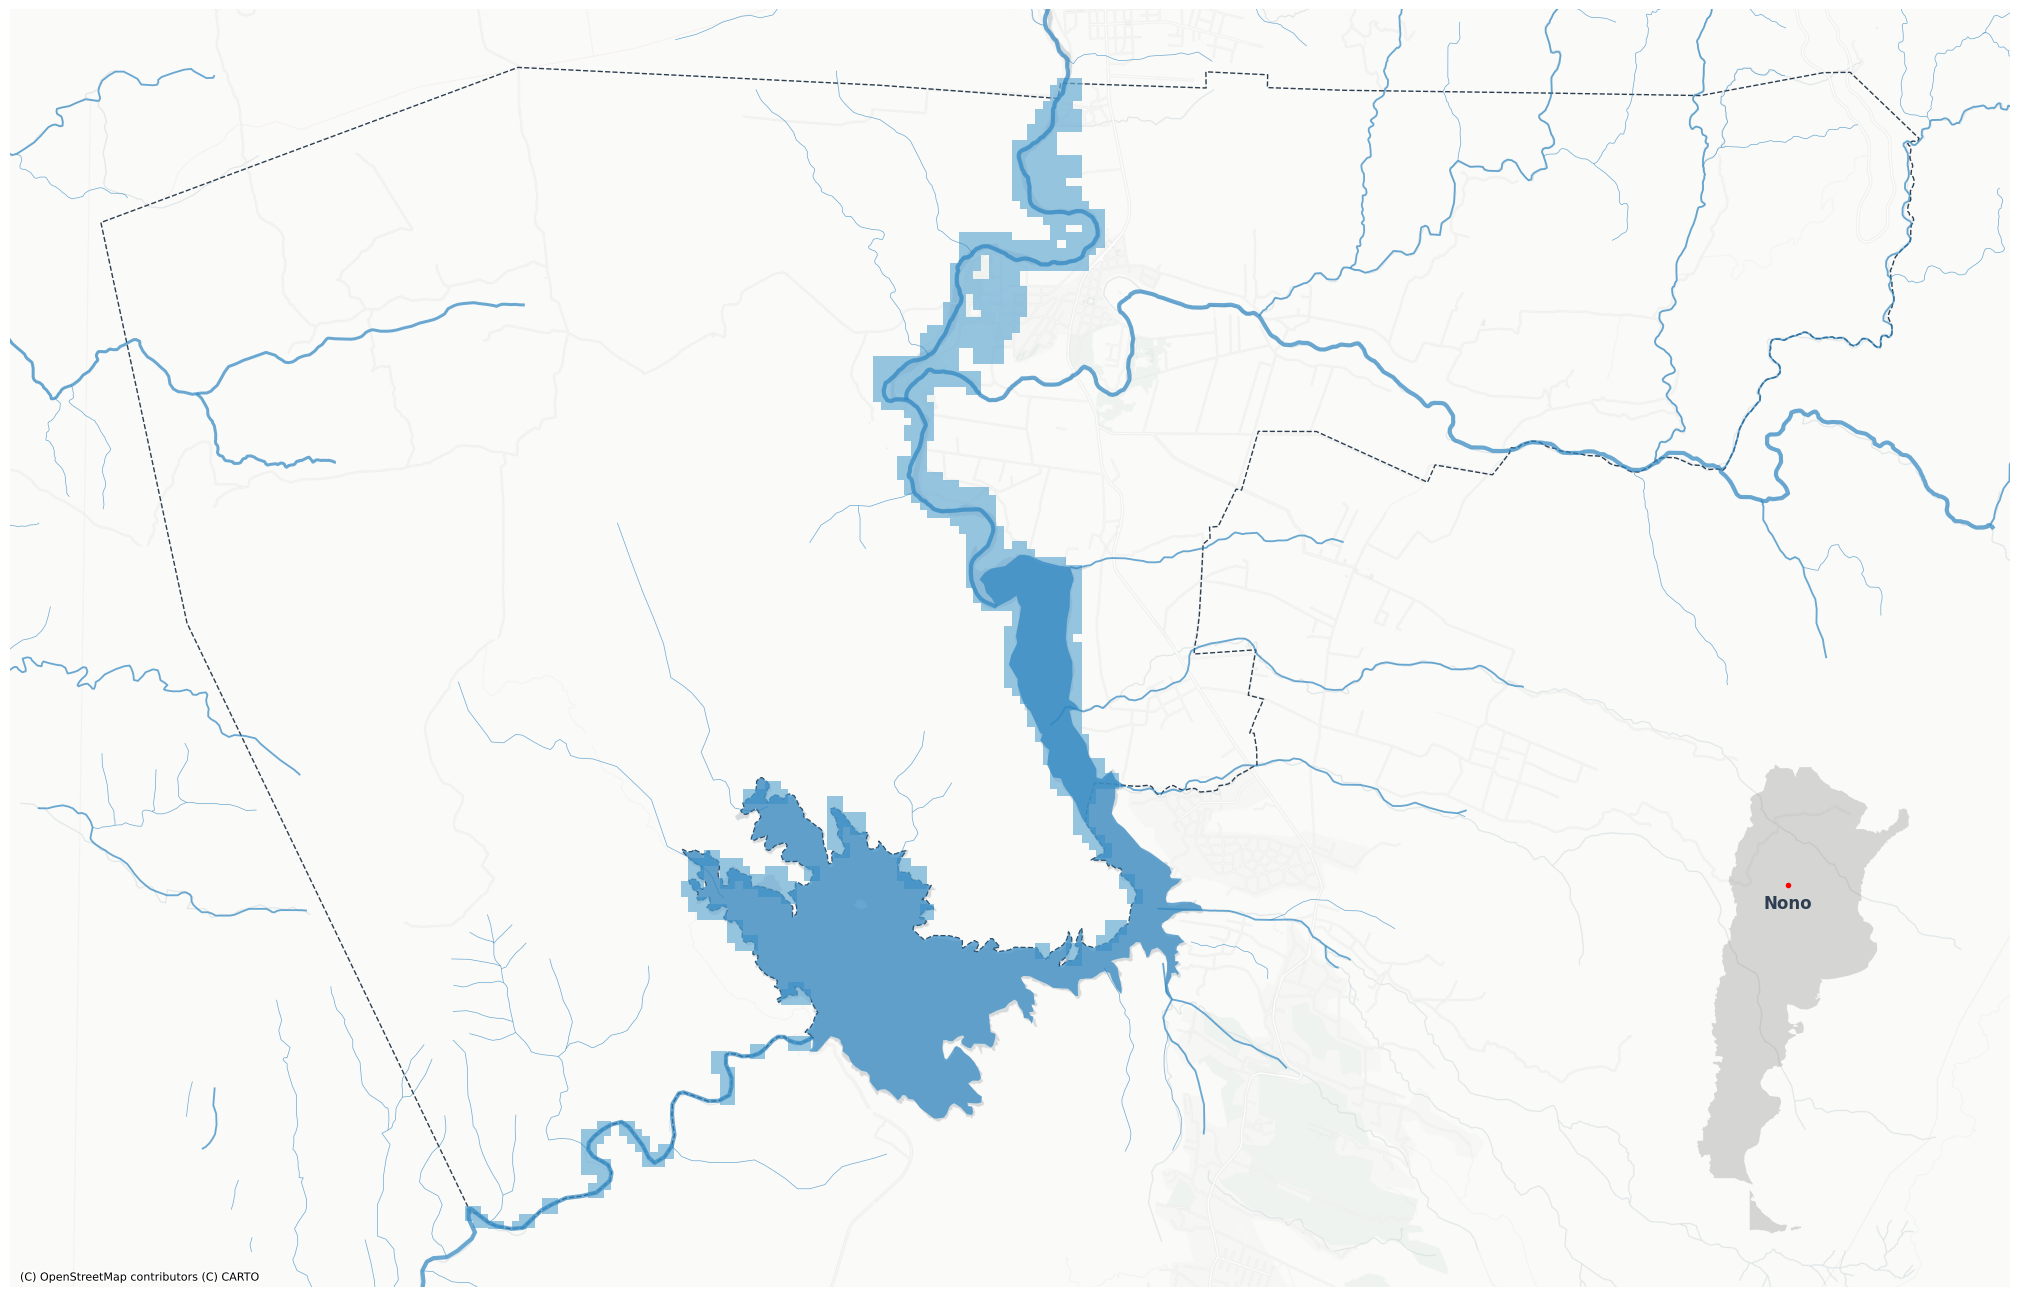

In [9]:
fig, ax = plt.subplots(figsize=VIZ["figsize_single"])

bounds = nono_3857.total_bounds
width = bounds[2] - bounds[0]
height = bounds[3] - bounds[1]
padding_x = width * 0.05
padding_y = height * 0.05
ax.set_xlim(bounds[0] - padding_x, bounds[2] + padding_x)
ax.set_ylim(bounds[1] - padding_y, bounds[3] + padding_y)

# Create datashader canvas
canvas = ds.Canvas(plot_width=1500, plot_height=1500)

# Create mask for flood areas (where flood depth > 0)
flood_mask = flood_depth_3857 > 0

# Rasterize the flood mask
flood_agg = canvas.raster(flood_mask.sel(band=1))

# Add basemap first with explicit zoom level
ctx.add_basemap(
    ax,
    crs=flood_depth_3857.rio.crs,
    source=ctx.providers.CartoDB.PositronNoLabels,
    zorder=VIZ["zorder_background"],
    zoom=15,
)

# Plot the flood mask - only show where it's True
flood_agg.where(flood_agg > 0).plot.imshow(
    ax=ax,
    alpha=VIZ["alpha_main"],
    cmap="Blues",
    zorder=VIZ["zorder_main"],
    add_colorbar=False,
)

nono_3857.plot(
    ax=ax,
    facecolor="none",
    edgecolor=COLORS["boundary"],
    linestyle="--",
    linewidth=VIZ["linewidth_boundary"],
    zorder=VIZ["zorder_base"],
)

for orden in sorted(cursos_agua_nono_3857["orden"].unique()):
    subset = cursos_agua_nono_3857[cursos_agua_nono_3857["orden"] == orden]
    line_width = scale_line_width(orden)
    subset.plot(
        ax=ax,
        color=COLORS["water"],
        linewidth=line_width,
        alpha=VIZ["alpha_main"],
        zorder=VIZ["zorder_main"],
    )

cuerpos_de_agua_nono_3857.plot(
    ax=ax, color=COLORS["water"], alpha=VIZ["alpha_main"], zorder=VIZ["zorder_main"]
)

axins = inset_axes(
    ax,
    width="40%",
    height="40%",
    loc="lower right",
    bbox_to_anchor=(0.1, 0.02, 1, 1),
    bbox_transform=ax.transAxes,
)

argentina_3857.plot(
    ax=axins,
    facecolor="grey",
    edgecolor="none",
    linewidth=0.8,
    alpha=0.3,
    zorder=VIZ["zorder_base"],
)

# Set inset limits to show Argentina with some padding
inset_bounds = argentina_3857.total_bounds
inset_padding = (inset_bounds[2] - inset_bounds[0]) * 0.1
axins.set_xlim(inset_bounds[0] - inset_padding, inset_bounds[2] + inset_padding)
axins.set_ylim(inset_bounds[1] - inset_padding, inset_bounds[3] + inset_padding)

# Add point marker for Nono's location
nono_center = nono_3857.geometry.unary_union.centroid
axins.plot(
    nono_center.x,
    nono_center.y,
    marker="o",
    color="red",
    markersize=4,
    markeredgecolor="none",
    markeredgewidth=1,
    zorder=VIZ["zorder_highlight"],
)

# Add text label for Nono
axins.text(
    nono_center.x,
    nono_center.y - 100000,
    "Nono",
    fontsize=VIZ["fontsize_annotation"],
    ha="center",
    va="top",
    color=COLORS["text"],
    fontweight="bold",
    bbox=dict(
        boxstyle="round,pad=0.2",
        facecolor="none",
        alpha=VIZ["alpha_text"],
        edgecolor="none",
    ),
    zorder=VIZ["zorder_text"],
)

ax.set_axis_off()
axins.set_axis_off()

# Add a clean border around the inset map
for spine in axins.spines.values():
    spine.set_visible(True)
    spine.set_color = "black"
    spine.set_linewidth(1)

# Remove all padding
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.show()

In [10]:
ghsl_url = (
    "https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/"
    "GHS_POP_GLOBE_R2023A/"
    "GHS_POP_E2025_GLOBE_R2023A_54009_100/"
    "V1-0/"
    "tiles/"
    "GHS_POP_E2025_GLOBE_R2023A_54009_100_V1_0_R13_C13.zip"
)
ghsl = load_raster_data(
    ghsl_url, "GHS_POP_E2025_GLOBE_R2023A_54009_100_V1_0_R13_C13.tif"
)

ghsl_3857 = ghsl.rio.reproject(
    dst_crs="EPSG:3857",
    resolution=100,
).rio.clip(nono_3857.geometry)

In [11]:
# Calculate centroid in Web Mercator first
center = nono_3857.geometry.centroid.iloc[0]

# Convert the centroid point to WGS84 for S2
center_wgs84 = gpd.GeoDataFrame(geometry=[center], crs="EPSG:3857").to_crs(epsg=4326)
center = center_wgs84.geometry.iloc[0]

# Get the S2 cell ID at level 10
cell = s2sphere.CellId.from_lat_lng(
    s2sphere.LatLng.from_degrees(center.y, center.x)
).parent(10)

# Configure S3 client for Source Cooperative
s3 = boto3.client(
    "s3",
    endpoint_url="https://data.source.coop",
    aws_access_key_id="",
    aws_secret_access_key="",
    config=Config(s3={"addressing_style": "path"}),
)

# List objects in the Argentina directory
response = s3.list_objects_v2(
    Bucket="vida",
    Prefix="google-microsoft-open-buildings/geoparquet/by_country_s2/country_iso=ARG/",
)

# Extract partition IDs from the keys
partitions = {
    obj["Key"].split("/")[-1].replace(".parquet", "")
    for obj in response.get("Contents", [])
}

# Check each level up to find a matching partition
for level in range(10, 0, -1):
    parent_id = str(cell.parent(level).id())

    if parent_id in partitions:
        break

# Initialize DuckDB connection
con = duckdb.connect()

# Install and load required extensions
con.execute("INSTALL spatial")
con.execute("LOAD spatial")

# Configure S3 settings
con.execute("SET s3_region='us-east-1'")
con.execute("SET s3_endpoint='data.source.coop'")
con.execute("SET s3_use_ssl=true")
con.execute("SET s3_url_style='path'")

# Convert Nono to WGS84 for spatial query
nono_wkt = nono_3857.to_crs(epsg=4326).geometry.iloc[0].wkt

# Now query with spatial filtering
query = f"""
SELECT 
    ST_AsText(geometry) as geometry_wkt,
    *
FROM read_parquet('s3://vida/google-microsoft-open-buildings/geoparquet/by_country_s2/country_iso=ARG/{parent_id}.parquet')
WHERE ST_Intersects(geometry, ST_GeomFromText('{nono_wkt}'))
"""
# query takes about 1.5 minutes to run
buildings = con.execute(query).df()

# Create GeoDataFrame using the WKT geometry column
buildings = gpd.GeoDataFrame(
    buildings,
    geometry=gpd.GeoSeries.from_wkt(buildings["geometry_wkt"]),
    crs="EPSG:4326",
)

buildings_3857 = buildings.to_crs(epsg=3857)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

/tmp/ipykernel_357263/742700818.py:105: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  nono_center = nono_3857.geometry.unary_union.centroid


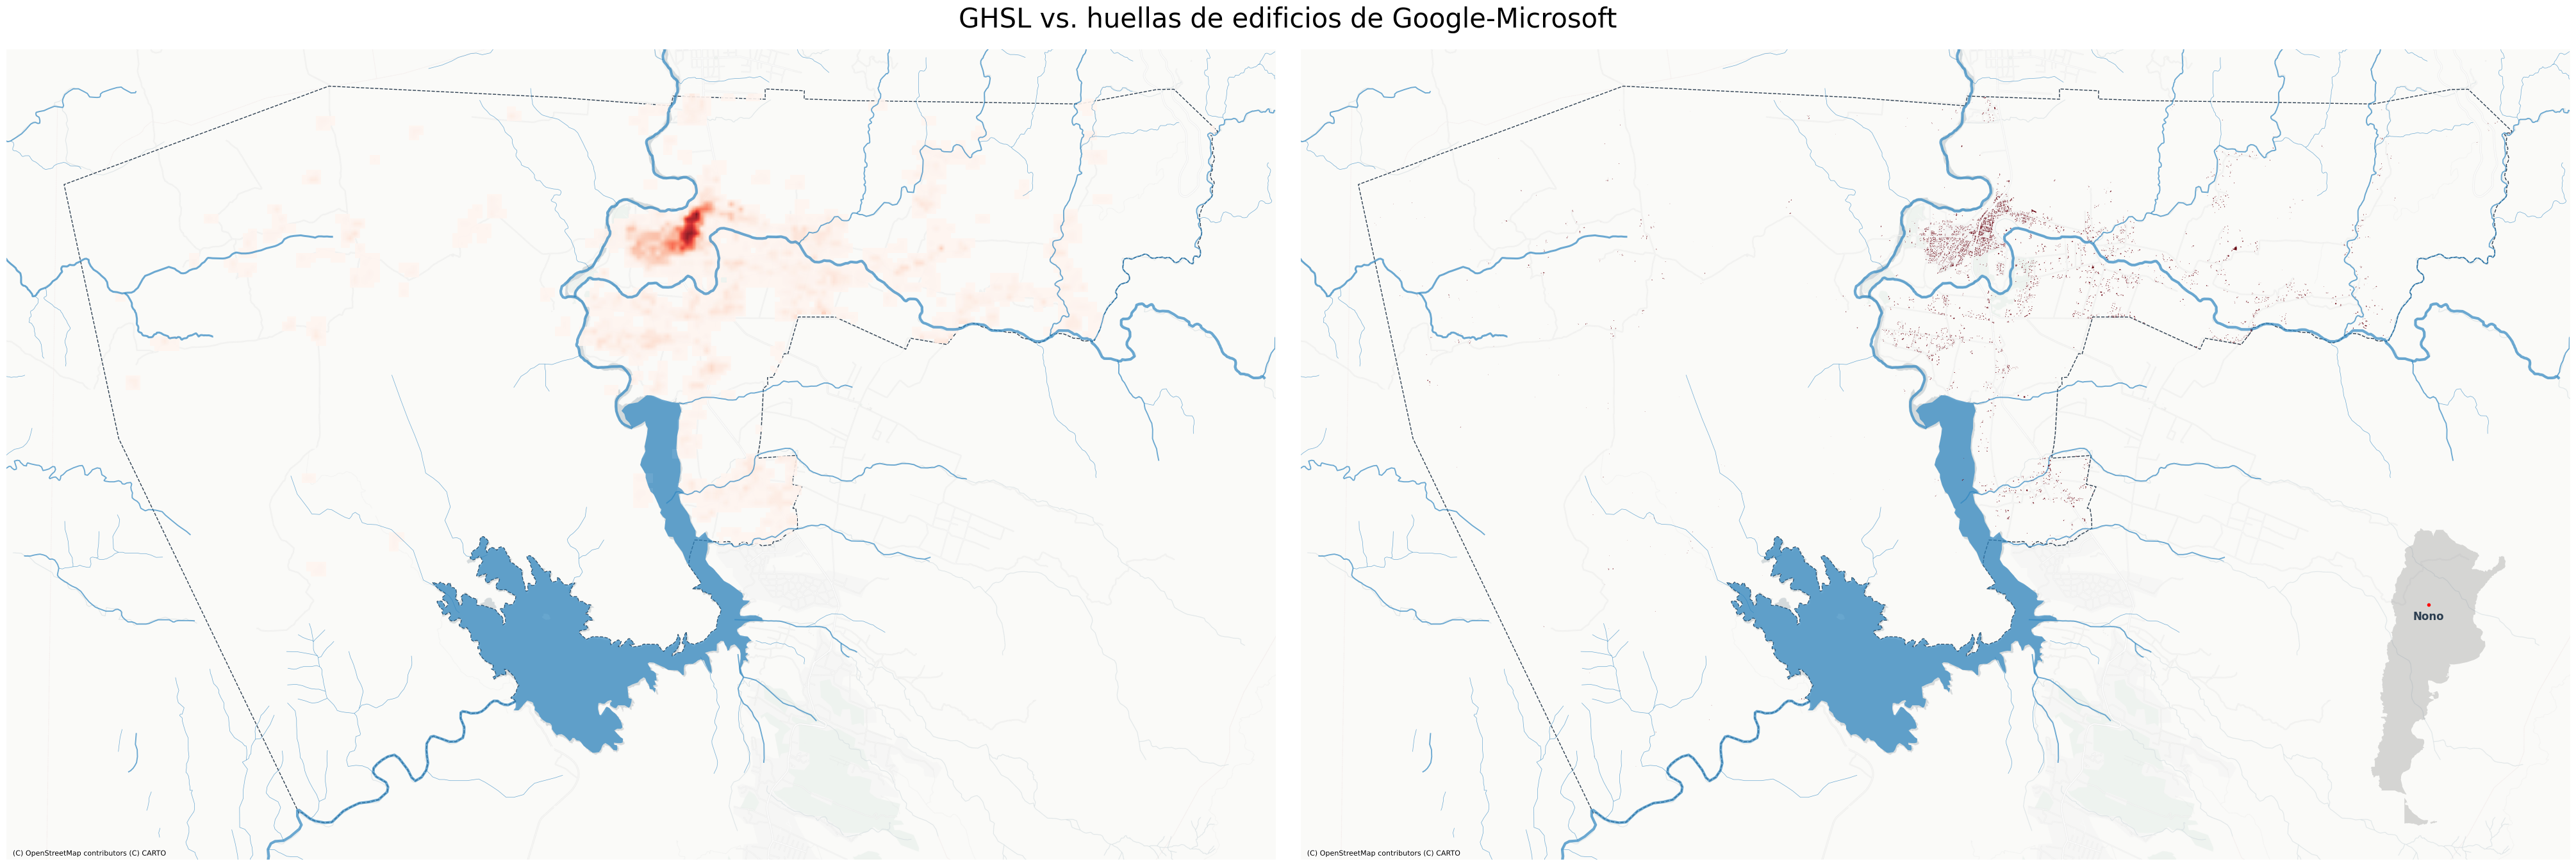

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=VIZ["figsize_dual"])

plt.suptitle(
    "GHSL vs. huellas de edificios de Google-Microsoft", fontsize=30, y=0.8
)  # Adjusted y position to be closer to plots

bounds = nono_3857.total_bounds
width = bounds[2] - bounds[0]
height = bounds[3] - bounds[1]
padding_x = width * 0.05
padding_y = height * 0.05

for ax in [ax1, ax2]:
    ax.set_xlim(bounds[0] - padding_x, bounds[2] + padding_x)
    ax.set_ylim(bounds[1] - padding_y, bounds[3] + padding_y)

canvas = ds.Canvas(plot_width=1500, plot_height=1500)

# Rasterize the GHSL data
ghsl_agg = canvas.raster(ghsl_3857.sel(band=1))

# Add basemap to both axes
for ax in [ax1, ax2]:
    ctx.add_basemap(
        ax,
        crs=ghsl_3857.rio.crs,
        source=ctx.providers.CartoDB.PositronNoLabels,
        zorder=VIZ["zorder_background"],
        zoom=15,
    )

ghsl_agg.where(ghsl_agg > 0).plot.imshow(
    ax=ax1,
    cmap="Reds",
    vmin=ghsl_agg.quantile(0.3),  # Start from 30th percentile
    vmax=ghsl_agg.max(),
    zorder=VIZ["zorder_main"],
    add_colorbar=False,
    alpha=0.9,  # Hard-coded alpha
)

# Plot vector data on both axes
for ax in [ax1, ax2]:
    nono_3857.plot(
        ax=ax,
        facecolor="none",
        edgecolor=COLORS["boundary"],
        linestyle="--",
        linewidth=VIZ["linewidth_boundary"],
        zorder=VIZ["zorder_base"],
    )

    # Plot water courses
    for orden in sorted(cursos_agua_nono_3857["orden"].unique()):
        subset = cursos_agua_nono_3857[cursos_agua_nono_3857["orden"] == orden]
        line_width = scale_line_width(orden)
        subset.plot(
            ax=ax,
            color=COLORS["water"],
            linewidth=line_width,
            alpha=VIZ["alpha_main"],
            zorder=VIZ["zorder_main"],
        )

    # Plot bodies of water
    cuerpos_de_agua_nono_3857.plot(
        ax=ax, color=COLORS["water"], alpha=VIZ["alpha_main"], zorder=VIZ["zorder_main"]
    )

# Plot buildings on second axis with darkest red
buildings_3857.plot(
    ax=ax2,
    color="#67000d",  # Hard-coded darkest red from Reds palette
    zorder=VIZ["zorder_main"],
    alpha=1.0,  # Hard-coded alpha
)

# Create inset map using inset_axes for the second plot
axins = inset_axes(
    ax2,
    width="40%",
    height="40%",
    loc="lower right",
    bbox_to_anchor=(0.1, 0.02, 1, 1),
    bbox_transform=ax2.transAxes,
)

# Plot Argentina outline in inset with white fill
argentina_3857.plot(
    ax=axins,
    facecolor="grey",
    edgecolor="none",
    linewidth=0.8,
    alpha=0.3,
    zorder=VIZ["zorder_base"],
)

# Set inset limits to show Argentina with some padding
inset_bounds = argentina_3857.total_bounds
inset_padding = (inset_bounds[2] - inset_bounds[0]) * 0.1
axins.set_xlim(inset_bounds[0] - inset_padding, inset_bounds[2] + inset_padding)
axins.set_ylim(inset_bounds[1] - inset_padding, inset_bounds[3] + inset_padding)

# Add point marker for Nono's location
nono_center = nono_3857.geometry.unary_union.centroid
axins.plot(
    nono_center.x,
    nono_center.y,
    marker="o",
    color="red",
    markersize=4,
    markeredgecolor="none",
    markeredgewidth=1,
    zorder=VIZ["zorder_highlight"],
)

# Add text label for Nono
axins.text(
    nono_center.x,
    nono_center.y - 100000,
    "Nono",
    fontsize=VIZ["fontsize_annotation"],
    ha="center",
    va="top",
    color=COLORS["text"],
    fontweight="bold",
    bbox=dict(
        boxstyle="round,pad=0.2",
        facecolor="none",
        alpha=VIZ["alpha_text"],
        edgecolor="none",
    ),
    zorder=VIZ["zorder_text"],
)

# Remove axis labels and ticks from all maps
for ax in [ax1, ax2, axins]:
    ax.set_axis_off()

# Add a clean border around the inset map
for spine in axins.spines.values():
    spine.set_visible(True)
    spine.set_color = "black"
    spine.set_linewidth(1)

# Remove all padding
plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0, wspace=0.02)

plt.show()

In [13]:
def union(x):
    return unary_union(x)


# Create mask for flood areas (where flood depth > 0)
flood_mask = flood_depth_3857 > 0

# Get coordinates and values
x, y = flood_depth_3857.x.values, flood_depth_3857.y.values
x, y = np.meshgrid(x, y)
x, y = x.flatten(), y.flatten()
values = flood_mask.sel(band=1).values.flatten()

# Convert to DataFrame and filter for flood areas
flood_pd = pd.DataFrame.from_dict({"flood": values, "x": x, "y": y})
flood_pd = flood_pd[flood_pd["flood"]]  # Simplified boolean comparison

# Create vector data
flood_vector = gpd.GeoDataFrame(
    geometry=gpd.GeoSeries.from_xy(
        flood_pd["x"], flood_pd["y"], crs=flood_depth_3857.rio.crs
    )
)
flood_vector = flood_vector.buffer(50, cap_style=3)  # Buffer to create polygons

# Convert to list of geometries and chunk for parallel processing
geoms = list(flood_vector.geometry)
geom_arr = [geoms[i : i + 10000] for i in range(0, len(geoms), 10000)]

# Parallel union operation
with Pool(cpu_count()) as p:
    geom_union = p.map(union, geom_arr)

# Final union
flood_polygons = unary_union(geom_union)
flood_gdf = gpd.GeoDataFrame(
    geometry=gpd.GeoSeries(flood_polygons), crs=flood_depth_3857.rio.crs
)

# Calculate population statistics
affine = ghsl_3857.rio.transform()
stats = zonal_stats(
    flood_gdf.geometry.tolist(),
    ghsl_3857.sel(band=1).values,
    stats=["sum"],
    nodata=-9999,
    affine=affine,
)
population_in_flood = sum(stat["sum"] for stat in stats if stat["sum"] is not None)
total_population = ghsl_3857.sel(band=1).sum().item()
population_percentage = (population_in_flood / total_population) * 100

# Calculate building statistics
buildings_in_flood = gpd.sjoin(
    buildings_3857, flood_gdf, how="inner", predicate="within"
)
total_buildings = len(buildings_3857)
buildings_exposed = len(buildings_in_flood)
buildings_percentage = (buildings_exposed / total_buildings) * 100

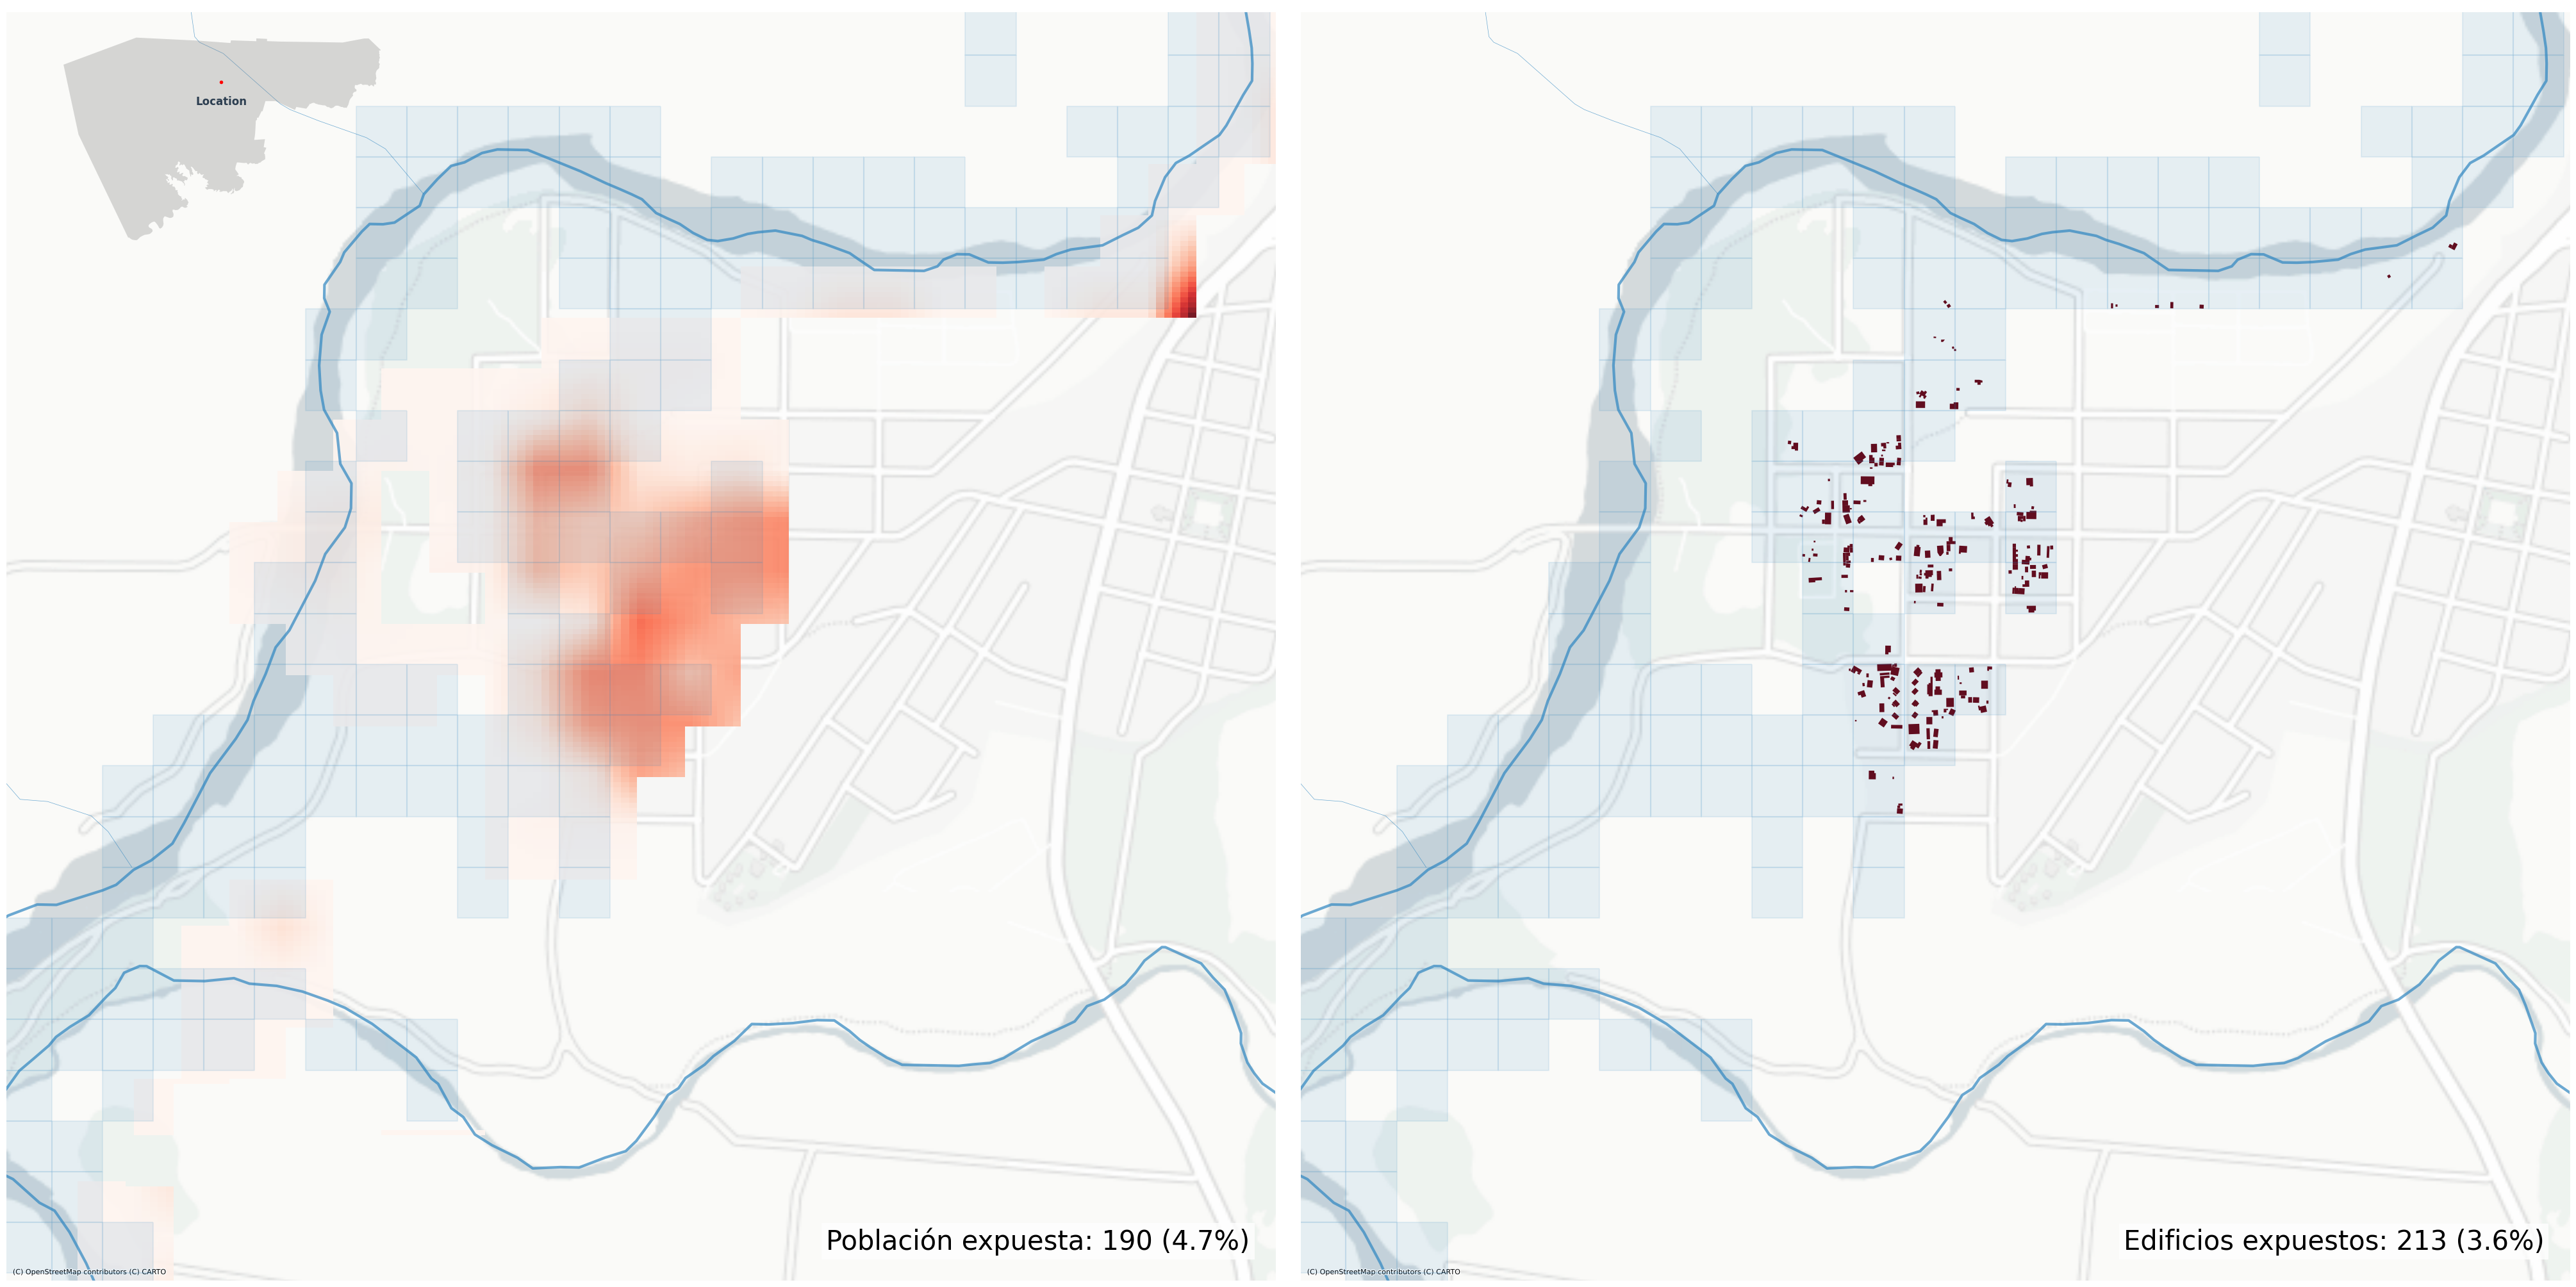

In [14]:
# Calculate weighted centroid
weighted_x = (
    buildings_in_flood.geometry.centroid.x * buildings_in_flood.geometry.area
).sum() / buildings_in_flood.geometry.area.sum()
weighted_y = (
    buildings_in_flood.geometry.centroid.y * buildings_in_flood.geometry.area
).sum() / buildings_in_flood.geometry.area.sum()

# Create a square around the centroid
size = 2500  # meters
square = gpd.GeoDataFrame(
    geometry=[
        box(
            weighted_x - size / 2,
            weighted_y - size / 2,
            weighted_x + size / 2,
            weighted_y + size / 2,
        )
    ],
    crs=buildings_in_flood.crs,
)

# Get the bounds of our square
square_bounds = square.total_bounds

# Create the figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=VIZ["figsize_dual"])

# Set the plot limits to match our square
for ax in [ax1, ax2]:
    ax.set_xlim(square_bounds[0], square_bounds[2])
    ax.set_ylim(square_bounds[1], square_bounds[3])

# Create inset axes for the second plot
axins = ax1.inset_axes([0.02, 0.75, 0.3, 0.3])

# Plot Nono boundary in inset
nono_3857.plot(
    ax=axins,
    facecolor="grey",
    edgecolor="none",
    linewidth=0.8,
    alpha=0.3,
    zorder=VIZ["zorder_highlight"],
)

# Set inset limits to show Nono with some padding
inset_bounds = nono_3857.total_bounds
inset_padding = (inset_bounds[2] - inset_bounds[0]) * 0.1
axins.set_xlim(inset_bounds[0] - inset_padding, inset_bounds[2] + inset_padding)
axins.set_ylim(inset_bounds[1] - inset_padding, inset_bounds[3] + inset_padding)

# Add point marker for weighted centroid location
axins.plot(
    weighted_x,
    weighted_y,
    marker="o",
    color="red",
    markersize=4,
    markeredgecolor="none",
    markeredgewidth=1,
    zorder=VIZ["zorder_highlight"],
)

# Add text label for the centroid
axins.text(
    weighted_x,
    weighted_y - 1000,
    "Location",
    fontsize=VIZ["fontsize_annotation"],
    ha="center",
    va="top",
    color=COLORS["text"],
    fontweight="bold",
    bbox=dict(
        boxstyle="round,pad=0.2",
        facecolor="none",
        alpha=VIZ["alpha_text"],
        edgecolor="none",
    ),
    zorder=VIZ["zorder_text"],
)

# Remove axis labels and ticks from inset
axins.set_axis_off()

# Create datashader canvas
canvas = ds.Canvas(plot_width=1500, plot_height=1500)

# Create mask for flood areas (where flood depth > 0)
flood_mask = flood_depth_3857 > 0

# First rasterize the flood mask
flood_agg = canvas.raster(flood_mask.sel(band=1))

# Then rasterize GHSL data
ghsl_agg = canvas.raster(ghsl_3857.sel(band=1))

# Apply the mask to the rasterized data and remove zero population areas
masked_ghsl = ghsl_agg.where(flood_agg)
masked_ghsl = masked_ghsl.where(masked_ghsl > 0)  # Only show areas with population

# Add basemap to both axes
for ax in [ax1, ax2]:
    ctx.add_basemap(
        ax,
        crs=flood_depth_3857.rio.crs,
        source=ctx.providers.CartoDB.PositronNoLabels,
        zorder=VIZ["zorder_background"],
        zoom=15,
    )

# Plot the masked population data on first axis with darkest red
masked_ghsl.plot.imshow(
    ax=ax1,
    alpha=0.9,  # Hard-coded alpha
    cmap="Reds",
    vmin=masked_ghsl.quantile(0.3),  # Start from 30th percentile to use darkest 70%
    vmax=masked_ghsl.max(),
    zorder=VIZ["zorder_main"],
    add_colorbar=False,
)

# Plot vector data on both axes
for ax in [ax1, ax2]:
    nono_3857.plot(
        ax=ax,
        facecolor="none",
        edgecolor=COLORS["boundary"],
        linestyle="--",
        linewidth=VIZ["linewidth_boundary"],
        zorder=VIZ["zorder_base"],
    )

    # Plot water courses
    for orden in sorted(cursos_agua_nono_3857["orden"].unique()):
        subset = cursos_agua_nono_3857[cursos_agua_nono_3857["orden"] == orden]
        line_width = scale_line_width(orden)
        subset.plot(
            ax=ax,
            color=COLORS["water"],
            linewidth=line_width,
            alpha=VIZ["alpha_main"],
            zorder=VIZ["zorder_main"],
        )

        # Plot bodies of water
        cuerpos_de_agua_nono_3857.plot(
            ax=ax,
            color=COLORS["water"],
            alpha=VIZ["alpha_main"],
            zorder=VIZ["zorder_main"],
        )

    # Plot flood vector layer last (so it's on top)
    flood_vector.plot(
        ax=ax,
        facecolor=COLORS["water"],
        edgecolor=COLORS["water"],
        alpha=0.1,  # Very transparent fill
        linewidth=1.5,
        zorder=VIZ["zorder_highlight"],  # Using highest zorder to ensure it's on top
    )

# Plot only exposed buildings on second axis with darkest red
buildings_in_flood.plot(
    ax=ax2,
    color="#67000d",  # Hard-coded darkest red from Reds palette
    zorder=VIZ["zorder_main"],
    alpha=1.0,  # Hard-coded alpha
)

# Add exposure statistics to each subfigure
# Population exposure stats for first subfigure
ax1.text(
    0.98,
    0.02,
    f"Población expuesta: {population_in_flood:,.0f} ({population_percentage:.1f}%)",
    transform=ax1.transAxes,
    ha="right",
    va="bottom",
    fontsize=30,
    bbox=dict(facecolor="white", alpha=0.8, edgecolor="none", pad=5),
    zorder=VIZ["zorder_text"],
)

# Building exposure stats for second subfigure
ax2.text(
    0.98,
    0.02,
    f"Edificios expuestos: {buildings_exposed:,} ({buildings_percentage:.1f}%)",
    transform=ax2.transAxes,
    ha="right",
    va="bottom",
    fontsize=30,
    bbox=dict(facecolor="white", alpha=0.8, edgecolor="none", pad=5),
    zorder=VIZ["zorder_text"],
)

# Remove axis labels and ticks
for ax in [ax1, ax2]:
    ax.set_axis_off()

# Remove all padding
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.02)

plt.show()

In [15]:
def load_all_return_periods(base_url, return_periods):
    """
    Load multiple return period flood depth rasters into a single xarray dataset.

    Parameters:
    -----------
    base_url : str
        Base URL for the flood depth data
    return_periods : list
        List of return periods to load (e.g., [10, 20, 50, 75, 100, 200, 500])

    Returns:
    --------
    xarray.Dataset
        Dataset containing all return period flood depths
    """
    start_time = time.time()
    logging.info(f"Starting to load {len(return_periods)} return periods")

    # Create empty list to store datasets
    datasets = []

    # Load each return period
    for i, rp in enumerate(return_periods, 1):
        logging.info(f"Loading return period {rp} ({i}/{len(return_periods)})")

        # Construct URL for this return period
        url = base_url.replace("RP100", f"RP{rp}")
        logging.info(f"  URL: {url}")

        # Load and reproject data
        flood_depth = rio.open_rasterio(url, masked=True)

        flood_depth_3857 = flood_depth.rio.reproject(
            dst_crs="EPSG:3857",
            resolution=100,  # 100m resolution
        )

        flood_depth_3857 = flood_depth_3857.rio.clip(nono_3857.geometry, from_disk=True)

        # Add return period as a dimension
        flood_depth_3857 = flood_depth_3857.expand_dims({"return_period": [rp]})

        datasets.append(flood_depth_3857)

    logging.info("Combining all datasets...")
    combined = xr.concat(datasets, dim="return_period")

    total_time = time.time() - start_time
    logging.info(
        f"Finished loading all return periods in {timedelta(seconds=int(total_time))}"
    )

    return combined


# Define return periods and base URL
return_periods = [10, 20, 50, 75, 100, 200, 500]
base_url = "https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/CEMS-GLOFAS/flood_hazard/RP100/ID74_S30_W70_RP100_depth.tif"

# Load all return periods
flood_depths = load_all_return_periods(base_url, return_periods)

# Calculate exposure for each return period
exposure_results = []

for rp in flood_depths.return_period.values:
    # Create mask for this return period
    flood_mask = flood_depths.sel(return_period=rp) > 0

    # Create flood polygons for this return period
    x, y = flood_depths.x.values, flood_depths.y.values
    x, y = np.meshgrid(x, y)
    x, y = x.flatten(), y.flatten()
    values = flood_mask.sel(band=1).values.flatten()

    # Convert to DataFrame and filter for flood areas
    flood_pd = pd.DataFrame.from_dict({"flood": values, "x": x, "y": y})
    flood_pd = flood_pd[flood_pd["flood"]]  # Simplified boolean comparison

    # Create vector data
    flood_vector = gpd.GeoDataFrame(
        geometry=gpd.GeoSeries.from_xy(
            flood_pd["x"], flood_pd["y"], crs=flood_depths.rio.crs
        )
    )
    flood_vector = flood_vector.buffer(50, cap_style=3)  # Buffer to create polygons

    # Convert to list of geometries and chunk for parallel processing
    geoms = list(flood_vector.geometry)
    geom_arr = [geoms[i : i + 10000] for i in range(0, len(geoms), 10000)]

    # Parallel union operation
    with Pool(cpu_count()) as p:
        geom_union = p.map(union, geom_arr)

    # Final union
    flood_polygons = unary_union(geom_union)
    flood_gdf = gpd.GeoDataFrame(
        geometry=gpd.GeoSeries(flood_polygons), crs=flood_depths.rio.crs
    )

    # Calculate population statistics using intersection
    stats = zonal_stats(
        flood_gdf.geometry.tolist(),
        ghsl_3857.sel(band=1).values,
        stats=["sum", "count"],
        nodata=-9999,
        affine=affine,
        all_touched=True,  # Include cells that touch the boundary
    )

    population_in_flood = sum(stat["sum"] for stat in stats if stat["sum"] is not None)
    total_population = ghsl_3857.sel(band=1).sum().item()
    population_percentage = (population_in_flood / total_population) * 100

    # Calculate building statistics using intersection
    buildings_in_flood = gpd.sjoin(
        buildings_3857, flood_gdf, how="inner", predicate="intersects"
    )
    total_buildings = len(buildings_3857)
    buildings_exposed = len(buildings_in_flood)
    buildings_percentage = (buildings_exposed / total_buildings) * 100

    exposure_results.append(
        {
            "return_period": rp,
            "population_exposed": population_in_flood,
            "population_percentage": population_percentage,
            "buildings_exposed": buildings_exposed,
            "buildings_percentage": buildings_percentage,
        }
    )

# Convert to DataFrame for easy analysis
exposure_df = pd.DataFrame(exposure_results)

# Convert return periods to annual probabilities
exposure_df["annual_probability"] = 1 / exposure_df["return_period"]

# Sort by probability (ascending)
exposure_df = exposure_df.sort_values("annual_probability")

2025-05-25 13:26:32,755 - INFO - Starting to load 7 return periods
2025-05-25 13:26:32,756 - INFO - Loading return period 10 (1/7)
2025-05-25 13:26:32,756 - INFO -   URL: https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/CEMS-GLOFAS/flood_hazard/RP10/ID74_S30_W70_RP10_depth.tif
2025-05-25 13:26:52,758 - INFO - Loading return period 20 (2/7)
2025-05-25 13:26:52,758 - INFO -   URL: https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/CEMS-GLOFAS/flood_hazard/RP20/ID74_S30_W70_RP20_depth.tif
2025-05-25 13:27:11,598 - INFO - Loading return period 50 (3/7)
2025-05-25 13:27:11,599 - INFO -   URL: https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/CEMS-GLOFAS/flood_hazard/RP50/ID74_S30_W70_RP50_depth.tif
2025-05-25 13:27:28,196 - INFO - Loading return period 75 (4/7)
2025-05-25 13:27:28,196 - INFO -   URL: https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/CEMS-GLOFAS/flood_hazard/RP75/ID74_S30_W70_RP75_depth.tif
2025-05-25 13:27:58,462 - INFO - Loading return period 100 (5/7)
2025-05-25 13:27:58,463 

In [16]:
# Fit curves for both population and buildings
from scipy.interpolate import interp1d

# Create smoother x values for the fit
x_fit = np.logspace(
    np.log10(exposure_df["annual_probability"].min()),
    np.log10(exposure_df["annual_probability"].max()),
    100,
)

# Fit population curve
f_pop = interp1d(
    exposure_df["annual_probability"],
    exposure_df["population_exposed"],
    kind="cubic",
    bounds_error=False,
    fill_value=(
        exposure_df["population_exposed"].iloc[0],
        exposure_df["population_exposed"].iloc[-1],
    ),
)
y_fit_pop = f_pop(x_fit)

# Fit buildings curve
f_build = interp1d(
    exposure_df["annual_probability"],
    exposure_df["buildings_exposed"],
    kind="cubic",
    bounds_error=False,
    fill_value=(
        exposure_df["buildings_exposed"].iloc[0],
        exposure_df["buildings_exposed"].iloc[-1],
    ),
)
y_fit_build = f_build(x_fit)

/tmp/ipykernel_357263/51807232.py:58: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  expected_impact = np.trapz(exp_sorted, prob_sorted)
/tmp/ipykernel_357263/51807232.py:241: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("plasma")


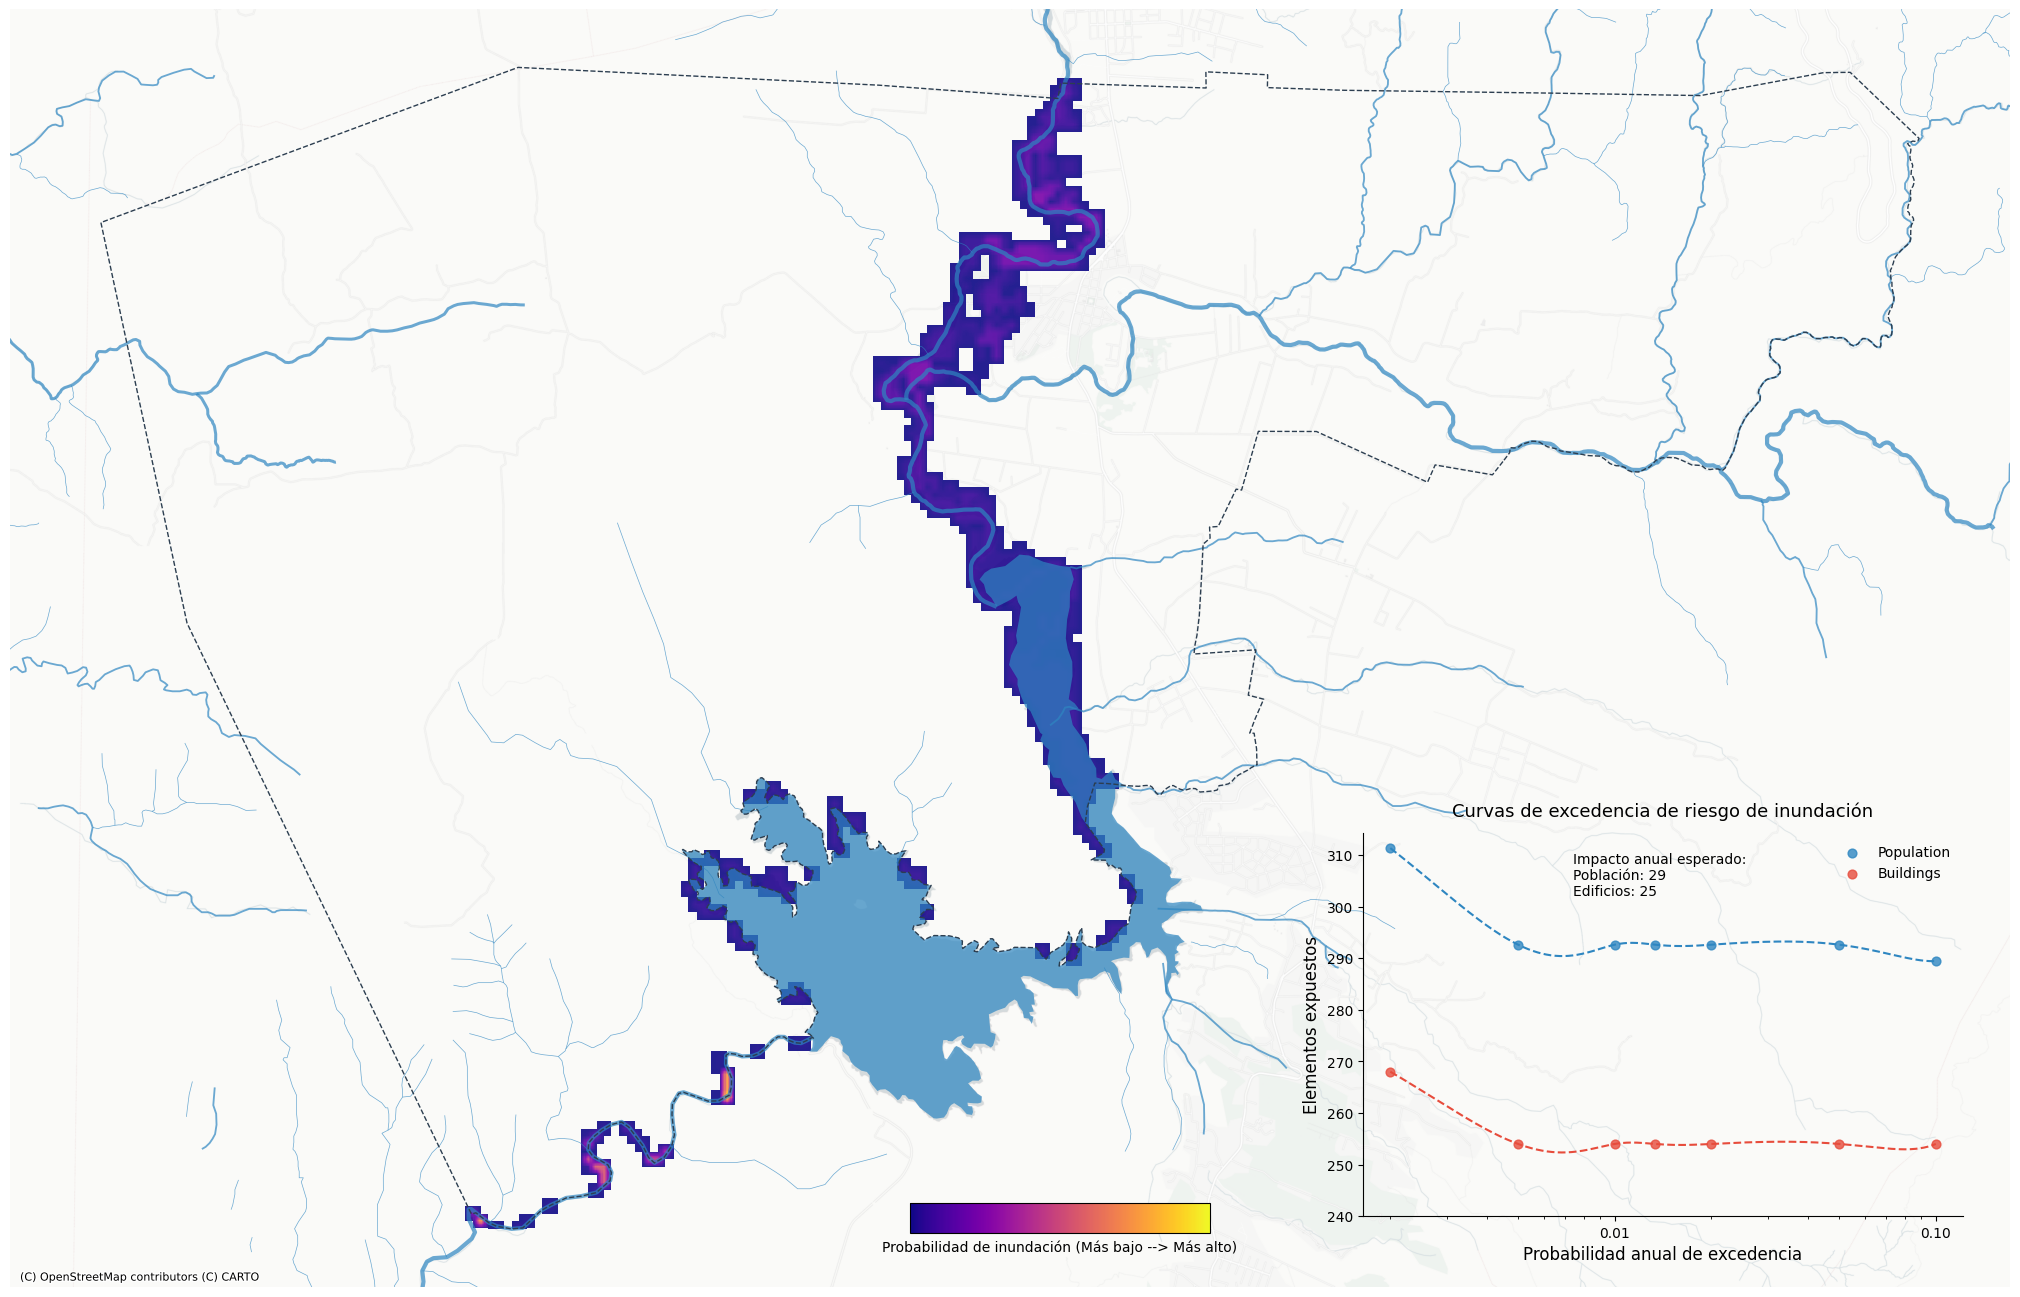

In [17]:
import numpy as np
from scipy.interpolate import interp1d
from scipy import integrate

# Create smoother x values for the fit
x_fit = np.logspace(
    np.log10(exposure_df["annual_probability"].min()),
    np.log10(exposure_df["annual_probability"].max()),
    1000,
)  # More points for better integration accuracy

# Fit population curve
f_pop = interp1d(
    exposure_df["annual_probability"],
    exposure_df["population_exposed"],
    kind="cubic",
    bounds_error=False,
    fill_value=(
        exposure_df["population_exposed"].iloc[0],
        exposure_df["population_exposed"].iloc[-1],
    ),
)
y_fit_pop = f_pop(x_fit)

# Fit buildings curve
f_build = interp1d(
    exposure_df["annual_probability"],
    exposure_df["buildings_exposed"],
    kind="cubic",
    bounds_error=False,
    fill_value=(
        exposure_df["buildings_exposed"].iloc[0],
        exposure_df["buildings_exposed"].iloc[-1],
    ),
)
y_fit_build = f_build(x_fit)


# Calculate expected annual impact by integrating the exceedance curve
def calculate_expected_annual_impact_from_exceedance(probabilities, exposures):
    """
    Calculate expected annual impact from exceedance curve.

    For an exceedance curve, the expected value is the integral of the curve
    from 0 to the maximum probability.

    Parameters:
    probabilities: array of annual exceedance probabilities (sorted ascending)
    exposures: array of corresponding exposure values
    """
    # Sort by probability to ensure proper integration
    sorted_indices = np.argsort(probabilities)
    prob_sorted = probabilities[sorted_indices]
    exp_sorted = exposures[sorted_indices]

    # Integrate using trapezoidal rule
    # This calculates the area under the curve
    expected_impact = np.trapz(exp_sorted, prob_sorted)

    return expected_impact


# Alternative method using scipy.integrate for the interpolated curves
def calculate_expected_annual_impact_smooth(prob_array, exposure_function):
    """
    Calculate expected annual impact using smooth interpolated curve.

    Parameters:
    prob_array: array of probability values
    exposure_function: interpolation function that gives exposure for given probability
    """
    # Integrate the interpolated function
    expected_impact, _ = integrate.quad(
        exposure_function, prob_array.min(), prob_array.max()
    )

    return expected_impact


# Method 1: Using original data points
expected_pop_discrete = calculate_expected_annual_impact_from_exceedance(
    exposure_df["annual_probability"].values, exposure_df["population_exposed"].values
)

expected_buildings_discrete = calculate_expected_annual_impact_from_exceedance(
    exposure_df["annual_probability"].values, exposure_df["buildings_exposed"].values
)

# Method 2: Using smooth interpolated curves
expected_pop = calculate_expected_annual_impact_smooth(x_fit, f_pop)
expected_buildings = calculate_expected_annual_impact_smooth(x_fit, f_build)

# Rest of the plotting code remains the same...
# Create a single subplot for the main map
fig, ax1 = plt.subplots(1, 1, figsize=(20, 15))

# Set the plot limits to match the Nono boundary for the map
bounds = nono_3857.total_bounds
width = bounds[2] - bounds[0]
height = bounds[3] - bounds[1]
padding_x = width * 0.05
padding_y = height * 0.05
ax1.set_xlim(bounds[0] - padding_x, bounds[2] + padding_x)
ax1.set_ylim(bounds[1] - padding_y, bounds[3] + padding_y)

# Create datashader canvas
canvas = ds.Canvas(plot_width=1500, plot_height=1500)

# Sum flood depths across return periods
flood_sum = flood_depths.sum(dim="return_period")

# Rasterize the summed flood data
flood_agg = canvas.raster(flood_sum.sel(band=1))

# Add basemap
ctx.add_basemap(
    ax1,
    crs=flood_depths.rio.crs,
    source=ctx.providers.CartoDB.PositronNoLabels,
    zorder=1,
    zoom=15,
)

# Plot the summed flood data
flood_agg.where(flood_agg > 0).plot.imshow(
    ax=ax1, cmap="plasma", zorder=2, add_colorbar=False, alpha=0.9
)

# Plot vector data
nono_3857.plot(
    ax=ax1,
    facecolor="none",
    edgecolor=COLORS["boundary"],
    linestyle="--",
    linewidth=1,
    zorder=4,
)

# Plot water courses
for orden in sorted(cursos_agua_nono_3857["orden"].unique()):
    subset = cursos_agua_nono_3857[cursos_agua_nono_3857["orden"] == orden]
    line_width = scale_line_width(orden)
    subset.plot(
        ax=ax1, color=COLORS["water"], linewidth=line_width, alpha=0.7, zorder=3
    )

# Plot bodies of water
cuerpos_de_agua_nono_3857.plot(ax=ax1, color=COLORS["water"], alpha=0.7, zorder=3)

# Create inset for exceedance curve using inset_axes
axins = inset_axes(
    ax1,
    width="30%",
    height="30%",
    loc="lower right",
    bbox_to_anchor=(-0.02, 0.05, 1, 1),
    bbox_transform=ax1.transAxes,
)

# Plot both population and buildings data points
axins.scatter(
    exposure_df["annual_probability"],
    exposure_df["population_exposed"],
    color="#2E86C1",  # Blue for population
    s=40,
    alpha=0.8,
    label="Population",
)

axins.scatter(
    exposure_df["annual_probability"],
    exposure_df["buildings_exposed"],
    color="#E74C3C",  # Red for buildings
    s=40,
    alpha=0.8,
    label="Buildings",
)

# Plot the fitted curves
axins.plot(
    x_fit, y_fit_pop, color="#2E86C1", linewidth=1.5, linestyle="--", label="_nolegend_"
)
axins.plot(
    x_fit,
    y_fit_build,
    color="#E74C3C",
    linewidth=1.5,
    linestyle="--",
    label="_nolegend_",
)

# Set labels and title for inset
# ... previous code remains the same until the inset plotting ...

# Set labels and title for inset
axins.set_xlabel("Probabilidad anual de excedencia", fontsize=12)
axins.set_ylabel("Elementos expuestos", fontsize=12)
axins.set_title("Curvas de excedencia de riesgo de inundación", fontsize=13, pad=12)

# Use log scale for x-axis and set y-axis to start at 0
axins.set_xscale("log")
axins.set_ylim(bottom=240)  # Set y-axis to start at 0
axins.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{x:.2f}"))

# Add legend
axins.legend(fontsize=10, frameon=False)

# Add expected annual impact text (moved to the right, no background)
axins.text(
    0.35,  # Moved from 0.05 to 0.35
    0.95,
    f"Impacto anual esperado:\nPoblación: {expected_pop:,.0f}\nEdificios: {expected_buildings:,.0f}",
    transform=axins.transAxes,
    verticalalignment="top",
    fontsize=10,
    color="black",  # Ensure text is visible
)

# ... rest of the code remains the same ...

# Clean minimal styling for inset
axins.grid(False)
axins.spines["top"].set_visible(False)
axins.spines["right"].set_visible(False)
axins.spines["left"].set_visible(True)
axins.spines["bottom"].set_visible(True)
axins.tick_params(axis="both", which="major", labelsize=10)

# Set white background with transparency for the entire inset area including labels
axins.patch.set_facecolor("none")
axins.patch.set_zorder(0)

# Remove axis labels and ticks from main map
ax1.set_axis_off()


# Get the maximum flood depth value for the colorbar normalization
max_flood_depth = flood_agg.max().item()

# Create a colormap and normalization object for the colorbar
cmap = cm.get_cmap("plasma")
norm = mcolors.Normalize(vmin=0, vmax=max_flood_depth)
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Create a new axes for the colorbar at the bottom of the figure
cbar_ax = fig.add_axes([0.45, 0.11, 0.15, 0.02])

# Create the colorbar using the ScalarMappable and the dedicated axes
cbar = fig.colorbar(sm, cax=cbar_ax, orientation="horizontal")

# Remove numeric labels and ticks from the colorbar
cbar.set_ticks([])
cbar.set_ticklabels([])

# Set the label for the colorbar
cbar.set_label(
    "Probabilidad de inundación (Más bajo --> Más alto)", fontsize=10, ha="center", labelpad=5
)

# Remove all padding
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.show()